In [324]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('bushfire.csv')
df.columns = df.iloc[0]
df.drop([0], inplace=True)
df.rename(columns={ df.columns[0]: "Year", "Ha Burnt": "ha_burnt"}, inplace = True)
df.dropna(subset=['ha_burnt'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

0     Year    Aug   Sep    Oct    Nov    Dec    Jan    Feb    Mar    Apr  \
0  1960-61   56.9  67.8  280.3   71.6  244.9   62.6     75     41   89.4   
1  1961-62  239.9  52.5   74.4  517.2  172.2  133.4  158.2   62.8  100.3   
2  1962-63  109.7  86.5   21.9   10.4  114.1  138.7   50.4  387.8  238.6   
3  1963-64  269.2  24.8   62.4   41.5  279.1   18.2     37  171.7  139.6   
4  1964-65   25.7  15.1   86.3   74.2     38   36.8   22.7    8.4   85.1   

0    May    Jun   Jul     Year Aug-Jan Sep-Jan Oct-Jan ha_burnt  
0   31.4     54    42  1960-61   784.1   727.2   659.4        0  
1  270.1    4.1  69.7  1961-62  1189.6   949.7   897.2        0  
2  211.1  264.8  67.2  1962-63   481.3   371.6   285.1        0  
3   78.1  407.5   9.5  1963-64   695.2     426   401.2        0  
4   42.6  236.3  97.8  1964-65   276.1   250.4   235.3   366000

In [86]:
df.to_csv('bushfire_clean.csv')

## Linear regression

In [564]:
# October to January
oj = np.array(df['Oct-Jan'])
oj = list(map(float, oj))
# September to January
sj = np.array(df['Sep-Jan'])
sj = list(map(float, sj))
# August to January
aj = np.array(df['Aug-Jan'])
aj = list(map(float, aj))
# hectares burnt
hectares = np.array(df['ha_burnt'])
hectares = list(map(float, hectares))

In [565]:
np.corrcoef(oj, hectares)

array([[ 1.        , -0.28050907],
       [-0.28050907,  1.        ]])

Coefficients: 
 [-1751.53639897]
Mean squared error: 146930944309.89
Coefficient of determination: -8.07


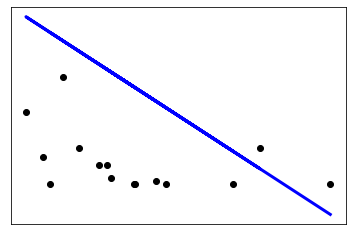

In [566]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# get the data
X, y = np.array(oj), hectares
X = X.reshape(-1, 1)

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [568]:
def rmse(y_test, y_pred): return np.sqrt(mean_squared_error(y_test, y_pred))

df_train, df_test = df[:45], df[45:]
X_train, y_train = df_train.drop(columns=['ha_burnt']), df_train.ha_burnt
X_test, y_test = df_test.drop(columns=['ha_burnt']), df_test.ha_burnt
regr.fit(X_train, y_train)
whole_preds = regr.predict(X_test)
rmse(y_test[:-1], whole_preds[:-1])

323087.1577892683

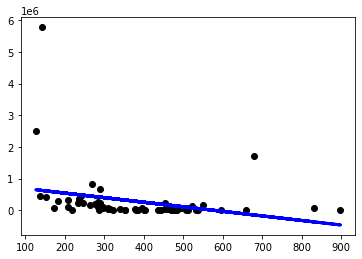

In [77]:
plt.scatter(X, y, color="black")
plt.plot(X, whole_preds, color="blue", linewidth=3)

In [79]:
data_mean, data_std = np.mean(y), np.std(y)
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in y if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in y if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Identified outliers: 1
Non-outlier observations: 59


### Adding a column for total hectares burnt in last five years

In [25]:
df = pd.read_csv("bushfire_clean.csv")
df.head()

Unnamed: 0     Year    Aug   Sep    Oct    Nov    Dec    Jan    Feb    Mar  \
0           0  1960-61   56.9  67.8  280.3   71.6  244.9   62.6   75.0   41.0   
1           1  1961-62  239.9  52.5   74.4  517.2  172.2  133.4  158.2   62.8   
2           2  1962-63  109.7  86.5   21.9   10.4  114.1  138.7   50.4  387.8   
3           3  1963-64  269.2  24.8   62.4   41.5  279.1   18.2   37.0  171.7   
4           4  1964-65   25.7  15.1   86.3   74.2   38.0   36.8   22.7    8.4   

     Apr    May    Jun   Jul   Year.1  Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  
0   89.4   31.4   54.0  42.0  1960-61    784.1    727.2    659.4         0  
1  100.3  270.1    4.1  69.7  1961-62   1189.6    949.7    897.2         0  
2  238.6  211.1  264.8  67.2  1962-63    481.3    371.6    285.1         0  
3  139.6   78.1  407.5   9.5  1963-64    695.2    426.0    401.2         0  
4   85.1   42.6  236.3  97.8  1964-65    276.1    250.4    235.3    366000

In [29]:
def previous_fires(df, previous):
    # adds a column for recent bushfire severity
    lst = []
    for i in range(len(df)):
        if i < previous: lst.append(0)
        else:
            toSum = np.array(df.ha_burnt.iloc[(i-previous):i])
            lst.append(np.sum(toSum))
    return lst

df['last_three_fire'] = pd.Series(previous_fires(df, 3))
df['last_fire'] = pd.Series(previous_fires(df, 1))
df['last_five_fire'] = pd.Series(previous_fires(df, 5))
df.head(10)

Unnamed: 0     Year    Aug    Sep    Oct    Nov    Dec    Jan    Feb  \
0           0  1960-61   56.9   67.8  280.3   71.6  244.9   62.6   75.0   
1           1  1961-62  239.9   52.5   74.4  517.2  172.2  133.4  158.2   
2           2  1962-63  109.7   86.5   21.9   10.4  114.1  138.7   50.4   
3           3  1963-64  269.2   24.8   62.4   41.5  279.1   18.2   37.0   
4           4  1964-65   25.7   15.1   86.3   74.2   38.0   36.8   22.7   
5           5  1965-66   11.3  101.3  177.8   34.2   61.1   23.0  139.3   
6           6  1966-67   88.4   56.0   58.5  166.2   96.7  163.1  153.7   
7           7  1967-68  179.8   98.1   74.0  126.8   44.0  134.0   19.3   
8           8  1968-69   31.6    5.1    6.7   17.7   90.9   35.7  255.5   
9           9  1969-70  161.3   56.9   47.3  266.5   36.5  142.8   49.0   

     Mar  ...    Jun   Jul   Year.1  Aug-Jan Sep-Jan  Oct-Jan  ha_burnt  \
0   41.0  ...   54.0  42.0  1960-61    784.1   727.2    659.4         0   
1   62.8  ...    4.1  69.7  1961-62   1189.6   949.7    897.2         0   
2  387.8  ...  264.8  67.2  1962-63    481.3   371.6    285.1         0   
3  171.7  ...  407.5   9.5  1963-64    695.2   426.0    401.2         0   
4    8.4  ...  236.3  97.8  1964-65    276.1   250.4    235.3    366000   
5  150.2  ...  138.8  13.0  1965-66    408.7   397.4    296.1     78000   
6  146.5  ...  244.8  29.1  1966-67    628.9   540.5    484.5         0   
7  103.3  ...   26.0  61.0  1967-68    656.7   476.9    378.8         0   
8   92.3  ...  206.2  49.2  1968-69    187.7   156.1    151.0    423000   
9  185.2  ...   43.6   1.8  1969-70    711.3   550.0    493.1     83000   

   last_three_fire  last_fire  last_five_fire  
0                0          0               0  
1                0          0               0  
2                0          0               0  
3                0          0               0  
4                0          0               0  
5           366000     366000          366000  
6           444000      78000          444000  
7           444000          0          444000  
8            78000          0          444000  
9           423000     423000          867000  

[10 rows x 22 columns]

In [30]:
df.to_csv("bushfire_engineered.csv")

# Tabular data exploration

In [684]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

Import the dataset, clean it.

In [685]:
df = pd.read_csv("bushfire_clean.csv")
df.drop(columns=['Unnamed: 0', 'Year', 'Year.1'], inplace=True)
cols = df.columns[df.dtypes.eq('object')]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df.head()

Aug   Sep    Oct    Nov    Dec    Jan    Feb    Mar    Apr    May    Jun  \
0   56.9  67.8  280.3   71.6  244.9   62.6   75.0   41.0   89.4   31.4   54.0   
1  239.9  52.5   74.4  517.2  172.2  133.4  158.2   62.8  100.3  270.1    4.1   
2  109.7  86.5   21.9   10.4  114.1  138.7   50.4  387.8  238.6  211.1  264.8   
3  269.2  24.8   62.4   41.5  279.1   18.2   37.0  171.7  139.6   78.1  407.5   
4   25.7  15.1   86.3   74.2   38.0   36.8   22.7    8.4   85.1   42.6  236.3   

    Jul  Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  
0  42.0    784.1    727.2    659.4         0  
1  69.7   1189.6    949.7    897.2         0  
2  67.2    481.3    371.6    285.1         0  
3   9.5    695.2    426.0    401.2         0  
4  97.8    276.1    250.4    235.3    366000

In [686]:
dep_var = 'ha_burnt'

In [687]:
train_idx = [x for x in range(0, 45)]
valid_idx = [x for x in range(45, 60)]
splits = (list(train_idx), list(valid_idx))

In [688]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [689]:
for var in cat:
    cont.append(var)
cat = []
cont

['Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec',
 'Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug-Jan',
 'Sep-Jan',
 'Oct-Jan']

In [690]:
to = TabularPandas(df, cat, cont, y_names=dep_var, splits=splits)

In [691]:
len(to.train), len(to.valid)

(45, 15)

In [692]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Decision tree

In [693]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

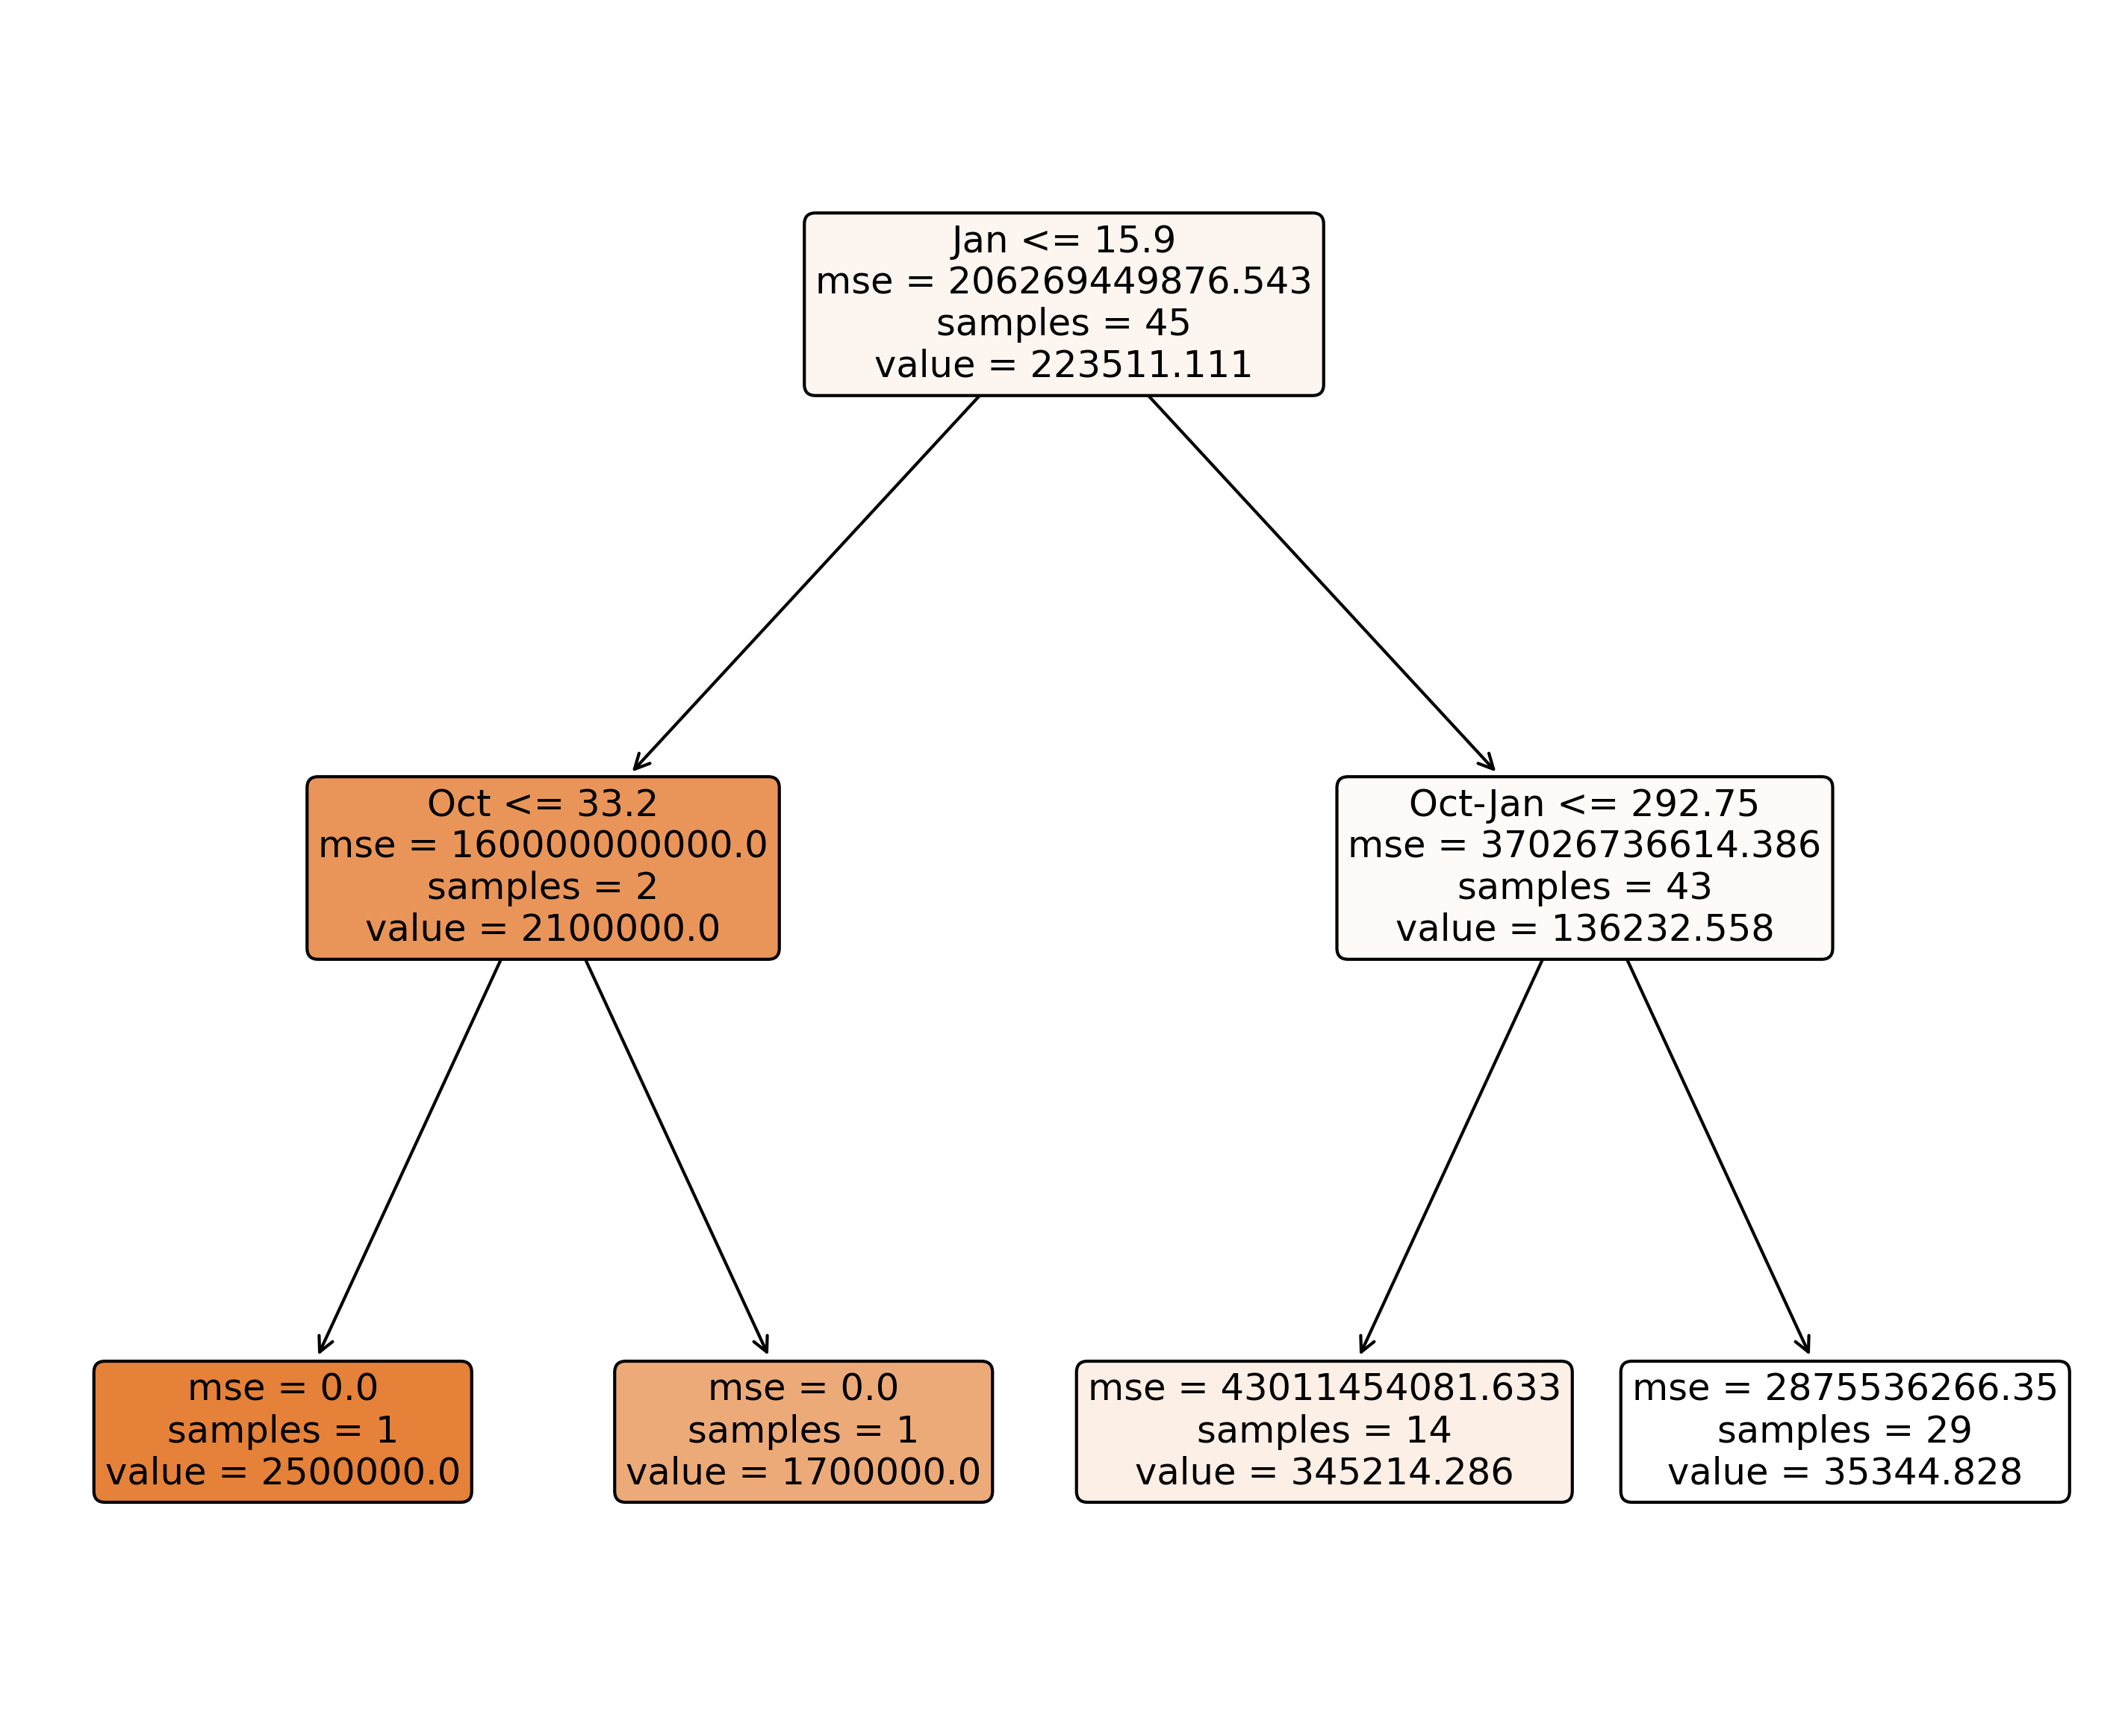

In [694]:
from sklearn import tree
fig = plt.figure(figsize=(12,10), dpi=300)
ax = fig.add_subplot()
tree.plot_tree(m, feature_names = cont, 
               class_names = dep_var,
              rounded=True,
              filled=True, ax = ax);
plt.savefig("decisiontree.png", dpi=300)

In [695]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [696]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [697]:
m_rmse(m, xs, y)

0.0

In [698]:
m_rmse(m, valid_xs, valid_y)

1289822.080754

In [699]:
m_rmse(m, valid_xs[:-1], valid_y[:-1])

179705.115596

In [700]:
m.get_n_leaves(), len(xs)

(31, 45)

## Random forest

In [701]:
def rf(xs, y, n_estimators=40, max_samples=45,
       max_features=3, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [702]:
m = rf(xs, y);

In [703]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(368298.704963, 1408699.276151)

In [704]:
m_rmse(m, xs, y), m_rmse(m, valid_xs[:-1], valid_y[:-1])

(368298.704963, 236098.595787)

In [705]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [706]:
r_mse(preds.mean(0), valid_y)

1408699.276151

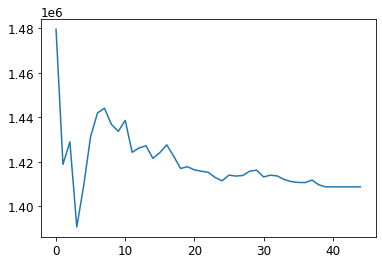

In [707]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(45)]);

In [708]:
r_mse(m.oob_prediction_, y)

445593.470237

### Tree variance for confidence prediction

In [709]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(40, 15)

In [710]:
preds_std = preds.std(0)
preds_std[:5]

array([250962.46234286, 306138.67221677, 150686.66441814, 339088.29628279, 348650.50555331])

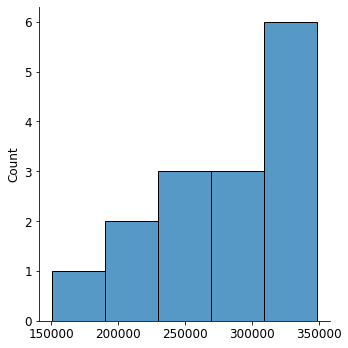

In [711]:
import seaborn as sns

sns.displot(preds_std);

### Feature importance

In [712]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [713]:
fi = rf_feat_importance(m, xs)
fi[:10]

cols       imp
14  Oct-Jan  0.171735
13  Sep-Jan  0.133995
5       Jan  0.126030
8       Apr  0.110251
0       Aug  0.101639
12  Aug-Jan  0.097054
4       Dec  0.074684
6       Feb  0.053330
2       Oct  0.048100
1       Sep  0.047504

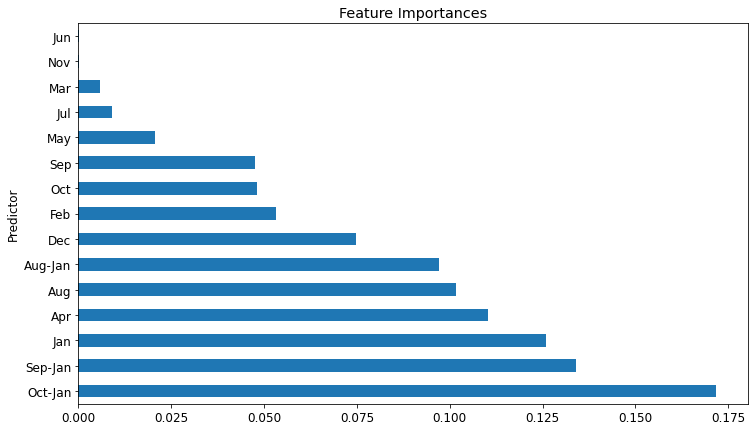

In [714]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', 
                   figsize=(12,7), xlabel = 'Predictor',
                   title = 'Feature Importances',
                   legend=False)

plot_fi(fi[:30]);

### Removing redundant features

In [715]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

13

In [716]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [717]:
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(367225.724001, 1412424.963833)

In [718]:
len(xs.columns), len(xs_imp.columns)

(15, 13)

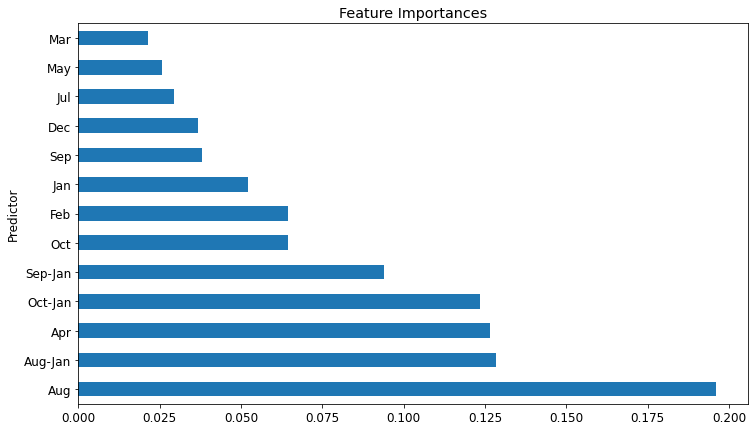

In [719]:
plot_fi(rf_feat_importance(m, xs_imp));

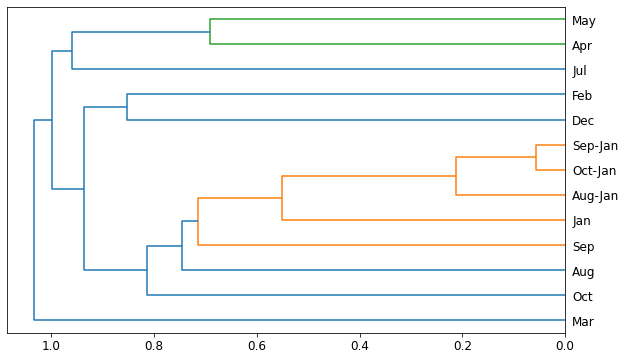

In [720]:
cluster_columns(xs_imp)

In [721]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=45, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [722]:
get_oob(xs_imp)

-0.052467309051897004

In [723]:
to_drop = ['Sep-Jan', 'Oct-Jan', 'Dec', 'Apr']
get_oob(xs_imp.drop(to_drop, axis=1))

-0.023728004257371094

In [724]:
to_drop = []
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [725]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(375391.359148, 1408006.921065)

### Partial dependence

In [726]:
valid_xs_final

Oct-Jan     Sep-Jan         Jan         Apr         Aug     Aug-Jan  \
45  314.600006  365.799988  121.400002    9.800000    1.600000  367.399994   
46  181.399994  373.399994   45.400002  179.600006   86.000000  459.399994   
47  377.200012  418.399994   57.000000  146.600006  152.199997  570.599976   
48  218.800003  318.000000   24.799999  152.600006   44.200001  362.200012   
49  296.000000  312.000000   36.000000   29.799999    6.000000  318.000000   
50  351.600006  393.799988   53.799999  206.199997   27.000000  420.799988   
51  403.000000  474.600006  138.800003  187.000000   52.200001  526.799988   
52  264.399994  288.200012  137.800003  199.800003   19.000000  307.200012   
53  283.399994  319.200012   17.400000  121.000000   14.800000  334.000000   
54  385.399994  435.799988  164.800003  366.799988  215.199997  651.000000   
55  512.000000  592.000000  249.800003  155.000000   71.800003  663.799988   
56  172.000000  242.000000   48.400002   82.599998  151.399994  393.399994   
57  209.000000  209.199997   37.799999   23.200001   24.200001  233.399994   
58  487.600006  538.599976   48.799999   11.200000    7.800000  546.400024   
59  141.399994  254.199997   79.400002   29.600000   73.000000  327.200012   

           Dec         Feb         Oct         Sep         May         Jul  \
45   25.200001   51.200001   43.000000   51.200001   40.400002  140.199997   
46   74.199997  107.599998   17.200001  192.000000    9.800000   67.199997   
47  123.199997  258.399994   27.000000   41.200001    3.000000   89.599998   
48   54.200001  127.599998   66.599998   99.199997  125.800003   53.000000   
49   66.800003  239.399994  180.000000   16.000000  168.399994  114.599998   
50   83.199997   18.000000   85.000000   42.200001  135.600006  282.200012   
51   78.400002  111.000000   37.400002   71.599998   37.200001   56.200001   
52   45.200001  165.399994   29.400000   23.799999  110.199997   32.599998   
53   31.000000   58.200001   42.200001   35.799999   27.400000   16.400000   
54  118.000000   59.000000   86.599998   50.400002  109.800003   47.000000   
55   96.599998   25.799999   43.000000   80.000000    7.200000  104.599998   
56   65.000000  205.199997   31.400000   70.000000   30.000000   12.600000   
57   47.200001  112.800003   62.799999    0.200000   23.200001   11.200000   
58   95.000000   85.400002  167.600006   51.000000   14.600000   43.400002   
59    1.600000  434.399994   34.200001  112.800003  138.199997  209.199997   

           Mar  
45   40.200001  
46   65.400002  
47   63.400002  
48   60.599998  
49   51.400002  
50  191.600006  
51  269.799988  
52   65.599998  
53  102.599998  
54   65.199997  
55  193.199997  
56  326.600006  
57  118.800003  
58  229.199997  
59  181.399994

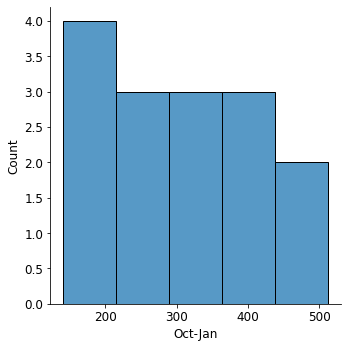

In [727]:
sns.displot(valid_xs_final['Oct-Jan']);

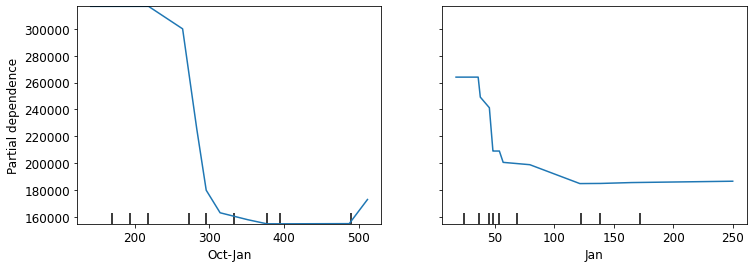

In [728]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['Oct-Jan','Jan'],
                        grid_resolution=20, ax=ax);

In [729]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [730]:
row = valid_xs_final.iloc[:5]

In [731]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [732]:
prediction[0], bias[0], contributions[0].sum()

(array([209721.07000638]), 203251.11111111115, 6469.95889527136)

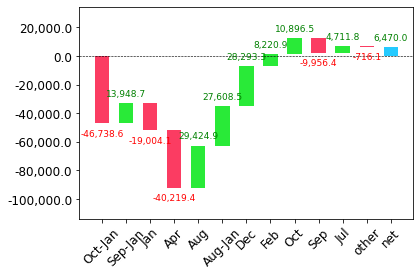

In [733]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45);

In [734]:
prediction = np.round(prediction).astype(int)
contributions = np.round(contributions).astype(int)

In [735]:
contributions

array([[-46739,  13949, -19004, -40219,  29425,  27608,  28293,   8221,  10896,  -9956,   -528,   4712,   -189],
       [118534,   4918,  40706,  65331,  -9127, -18000,  11911,  -6270,  18393,  -4315,      0,   3943,      0],
       [-48435,   1317,  -2850,  43980, -18003, -21758, -23765,  -1112,  12278,   3610,   -214,   2894,   -285],
       [115692,   6784,  64097,  33638,  -8743,  47153,   7328,  -6270, -10246,  -4315,      0,   3943,      0],
       [-29981,  13167,  58146, -35525,  38477,  37343,   3968,  -3090, -18290,   8347,   1583,   3549,   -209]])

## Neural network

In [736]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

cols       imp
10      May  0.141036
0   Oct-Jan  0.138563
2       Jan  0.133758
5   Aug-Jan  0.085258
11      Jul  0.082026
9       Sep  0.078755

In [737]:
df_mod = df
df_mod.ha_burnt = df_mod.ha_burnt +10
df.ha_burnt = df.ha_burnt.astype(float)
df_mod.head()

Aug   Sep    Oct    Nov    Dec    Jan    Feb    Mar    Apr    May    Jun  \
0   56.9  67.8  280.3   71.6  244.9   62.6   75.0   41.0   89.4   31.4   54.0   
1  239.9  52.5   74.4  517.2  172.2  133.4  158.2   62.8  100.3  270.1    4.1   
2  109.7  86.5   21.9   10.4  114.1  138.7   50.4  387.8  238.6  211.1  264.8   
3  269.2  24.8   62.4   41.5  279.1   18.2   37.0  171.7  139.6   78.1  407.5   
4   25.7  15.1   86.3   74.2   38.0   36.8   22.7    8.4   85.1   42.6  236.3   

    Jul  Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  
0  42.0    784.1    727.2    659.4      10.0  
1  69.7   1189.6    949.7    897.2      10.0  
2  67.2    481.3    371.6    285.1      10.0  
3   9.5    695.2    426.0    401.2      10.0  
4  97.8    276.1    250.4    235.3  366010.0

In [738]:
df_nn_final = df_mod[list(xs_final.columns) + [dep_var]]

In [739]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [740]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [741]:
dls = to_nn.dataloaders(8)

In [742]:
y = to_nn.train.y
y.min(),y.max()

(10.0, 2500010.0)

In [743]:
learn = tabular_learner(dls, y_range=(0,2500010.0), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.02754228748381138)

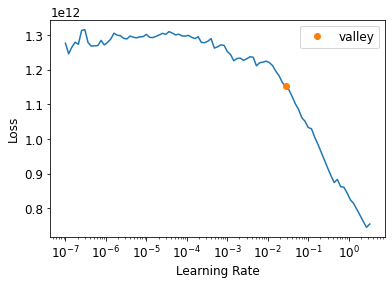

In [744]:
learn.lr_find()

In [745]:
learn.fit_one_cycle(100, 1e-2)

In [747]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

1495574.260704

# Time series forecasting

## Autoregression

In [760]:
from pandas.plotting import lag_plot
from matplotlib import pyplot
df = pd.read_csv("bushfire_clean.csv")

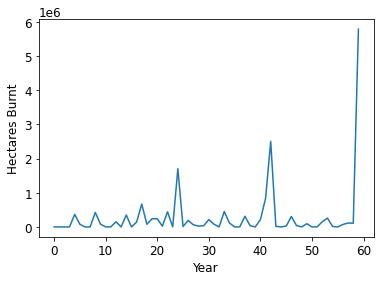

In [761]:
df.ha_burnt.plot(xlabel = 'Year', ylabel = 'Hectares Burnt')
pyplot.savefig("data.png",dpi=400)
pyplot.show()

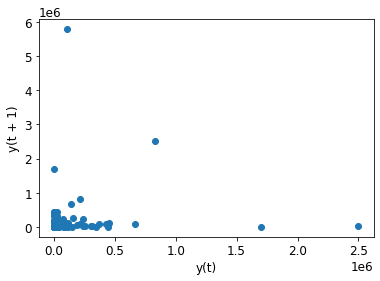

In [762]:
lag_plot(df.ha_burnt)
pyplot.savefig("scatter.png",dpi=300)
pyplot.show()

In [763]:
values = pd.DataFrame(df.ha_burnt.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.009341
t+1  0.009341  1.000000


### Autocorrelation plots

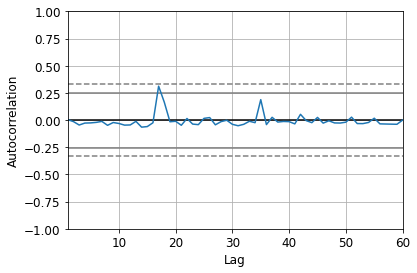

In [764]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.ha_burnt)
pyplot.savefig("Autocorrelation2.png",dpi=400)
pyplot.show()

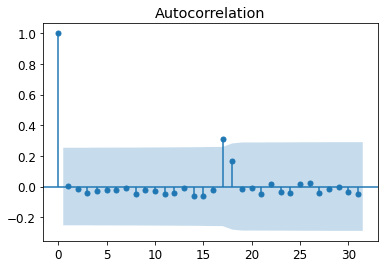

In [765]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.ha_burnt, lags=31)
pyplot.savefig("Autocorrelation.png",dpi=300)
pyplot.show()

### Persistence model

We remove the last observation as it is orders of mangitude greater than any other value in the dataset.

Test MSE: 2161974400000.000


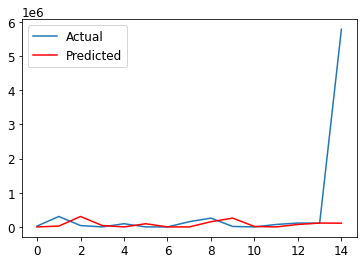

In [766]:
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = pd.DataFrame(df.ha_burnt.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-15], X[len(X)-15:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.legend(['Actual', 'Predicted'])
pyplot.savefig("persistence.png", dpi=300)
pyplot.show()

### Autoregression model

In [767]:
lst = [-1, -2, 4, 6, 7]
new_lst = [max(0, x) for x in lst]
new_lst

[0, 0, 4, 6, 7]

Coefficients: [ 1.20542043e+06 -1.98970402e-01 -4.45511206e-01 -4.65886002e-01 -1.98285029e-01 -2.22763152e-01 -2.39482046e-01 -1.78805247e-02 -2.70502584e-01 -5.56039650e-03 -1.58825942e-01 -5.96071072e-01
 -3.41999293e-01 -3.88264111e-01 -6.30240324e-01 -5.40809123e-01 -3.41692785e-01 -2.86556653e-02  9.56599775e-01]
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=24000.000000
predicted=531640.167521, expected=305000.000000
predicted=474582.978379, expected=40000.000000
predicted=245134.749894, expected=0.000000
predicted=396457.922830, expected=93000.000000
predicted=53100.786107, expected=0.000000
predicted=758098.429190, expected=0.000000
predicted=0.000000, expected=152000.000000
predicted=0.000000, expected=257000.000000
predicted=0.000000, expected=13000.000000
predicted=699171.643685, expected=0.000000
predicted=0.000000, expected=72000.000000
predicted=0.000000, expected=113000.000000
predicted=803458.286039, expected=109000.000000
Test RMSE: 369585.634


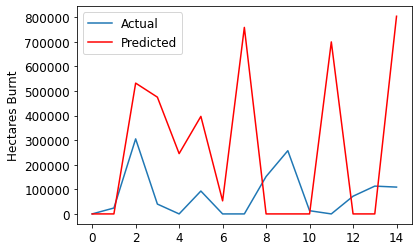

In [768]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# split dataset
X = df.ha_burnt.values[:-1]
train, test = X[1:len(X)-15], X[len(X)-15:]
# train autoregression
model = AutoReg(train, lags=18)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# clamp predictions at 0 (can't have negative bushfires)
predictions = [max(0, x) for x in predictions]
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.ylabel('Hectares Burnt')
pyplot.plot(predictions, color='red')
pyplot.legend(["Actual", "Predicted"])
pyplot.savefig("autoregression.png",dpi=300)
pyplot.show()

predicted=0.000000, expected=0.000000
predicted=0.000000, expected=24000.000000
predicted=141441.573493, expected=305000.000000
predicted=0.000000, expected=40000.000000
predicted=70487.521403, expected=0.000000
predicted=499992.453228, expected=93000.000000
predicted=202517.826178, expected=0.000000
predicted=1023462.337975, expected=0.000000
predicted=34779.808246, expected=152000.000000
predicted=0.000000, expected=257000.000000
predicted=0.000000, expected=13000.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=72000.000000
predicted=0.000000, expected=113000.000000
predicted=231275.408821, expected=109000.000000
Test RMSE: 305602.158


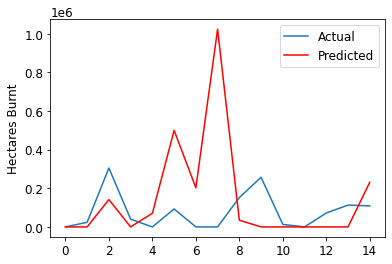

In [770]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
X = df.ha_burnt.values[:-1]
train, test = X[1:len(X)-15], X[len(X)-15:]
# train autoregression
window = 18
model = AutoReg(train, lags=18)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    if yhat < 0: yhat = 0
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.ylabel("Hectares Burnt")
pyplot.legend(["Actual", "Predicted"])
pyplot.savefig("autoregression2.png", dpi=300)
pyplot.show()

## Moving average

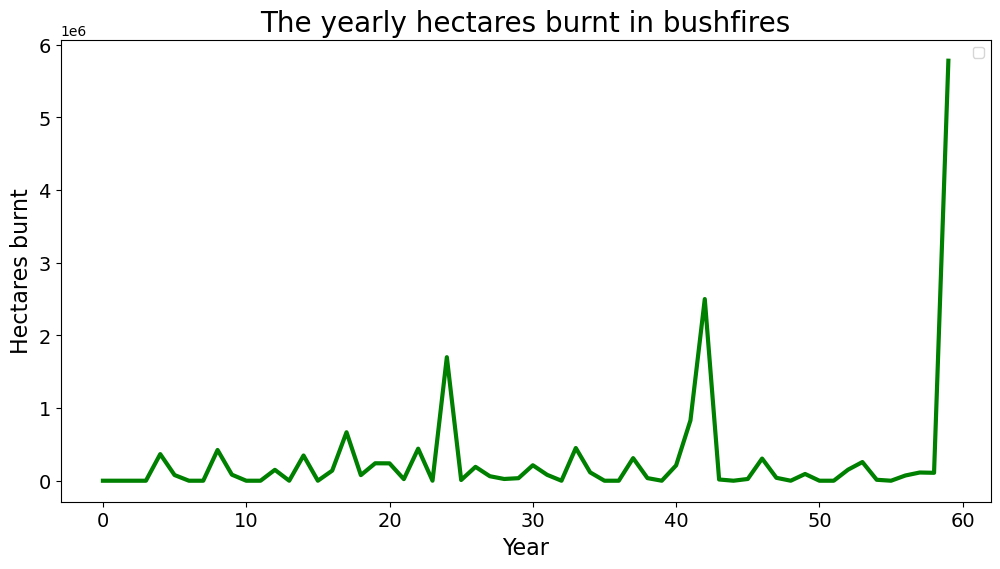

In [430]:
import matplotlib.pyplot as plt

# line plot - the yearly average air temperature in Barcelona
df.ha_burnt.plot(color='green', linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend('')

# title and labels
plt.title('The yearly hectares burnt in bushfires', fontsize=20);
plt.xlabel('Year', fontsize=16);
plt.ylabel('Hectares burnt', fontsize=16);

### Simple moving average

In [431]:
# the simple moving average over a period of 10 years
df['SMA_10'] = df.ha_burnt.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 years
df['SMA_20'] = df.ha_burnt.rolling(20, min_periods=1).mean()

df.head()

Unnamed: 0     Year    Aug   Sep    Oct    Nov    Dec    Jan    Feb    Mar  \
0           0  1960-61   56.9  67.8  280.3   71.6  244.9   62.6   75.0   41.0   
1           1  1961-62  239.9  52.5   74.4  517.2  172.2  133.4  158.2   62.8   
2           2  1962-63  109.7  86.5   21.9   10.4  114.1  138.7   50.4  387.8   
3           3  1963-64  269.2  24.8   62.4   41.5  279.1   18.2   37.0  171.7   
4           4  1964-65   25.7  15.1   86.3   74.2   38.0   36.8   22.7    8.4   

     Apr    May    Jun   Jul   Year.1  Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  \
0   89.4   31.4   54.0  42.0  1960-61    784.1    727.2    659.4         0   
1  100.3  270.1    4.1  69.7  1961-62   1189.6    949.7    897.2         0   
2  238.6  211.1  264.8  67.2  1962-63    481.3    371.6    285.1         0   
3  139.6   78.1  407.5   9.5  1963-64    695.2    426.0    401.2         0   
4   85.1   42.6  236.3  97.8  1964-65    276.1    250.4    235.3    366000   

    SMA_10   SMA_20  
0      0.0      0.0  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4  73200.0  73200.0

Text(103.72222222222221, 0.5, 'Hectares burnt')

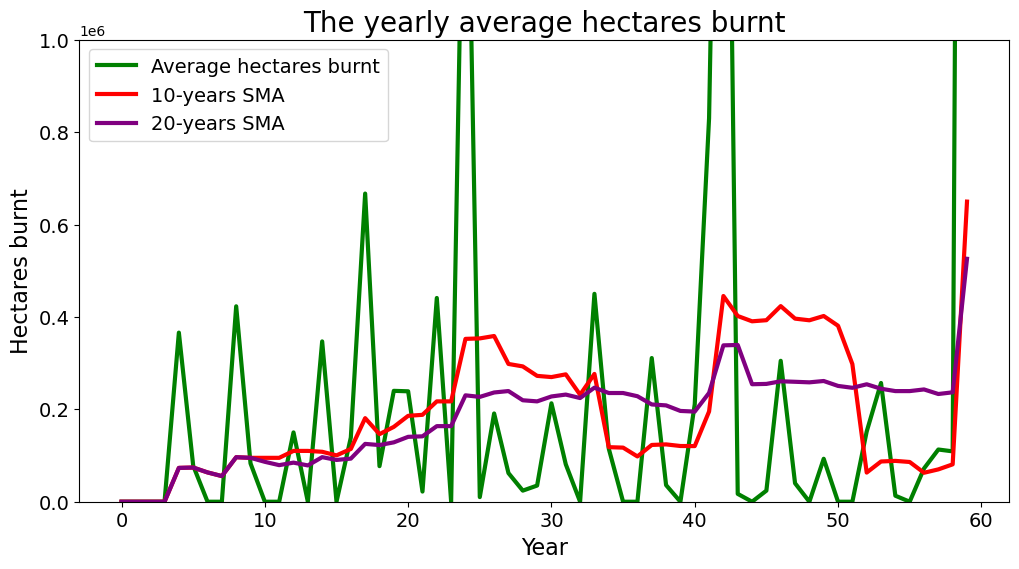

In [439]:
# colors for the line plot
colors = ['green', 'red', 'purple']

# line plot - the yearly average hectares burnt
df.ha_burnt.plot(color='green', linewidth=3, figsize=(12,6))
df.SMA_10.plot(color='red', linewidth=3, figsize=(12,6))
df.SMA_20.plot(color='purple', linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average hectares burnt', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average hectares burnt', fontsize=20)
plt.ylim(0, 1000000)
plt.xlabel('Year', fontsize=16)
plt.savefig('sma.png', dpi=300)
plt.ylabel('Hectares burnt', fontsize=16)

### Cumulative moving average

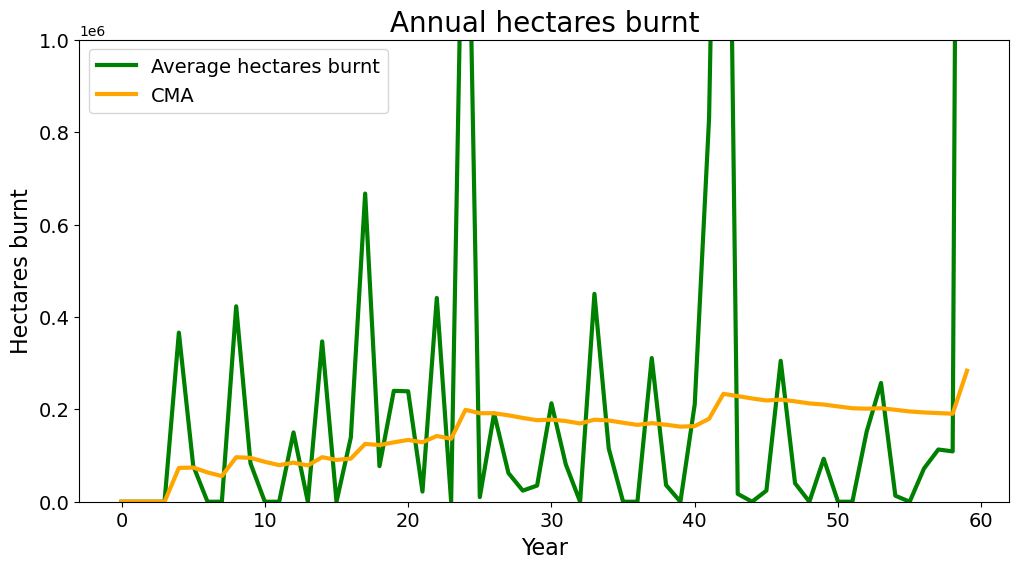

In [442]:
# cumulative moving average
df['CMA'] = df.ha_burnt.expanding().mean()

# colors for the line plot
colors = ['green', 'orange']

# line plot - the yearly average air temperature in Barcelona
df[['ha_burnt', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average hectares burnt', 'CMA'], fontsize=14)

# title and labels
plt.title('Annual hectares burnt', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Hectares burnt', fontsize=16)
plt.ylim(0, 1000000)
plt.savefig('cma.png', dpi=300)

### Exponential moving average

In [443]:
# smoothing factor - 0.1
df['EMA_0.1'] = df.ha_burnt.ewm(alpha=0.1, adjust=False).mean()

# smoothing factor - 0.3
df['EMA_0.3'] = df.ha_burnt.ewm(alpha=0.3, adjust=False).mean()

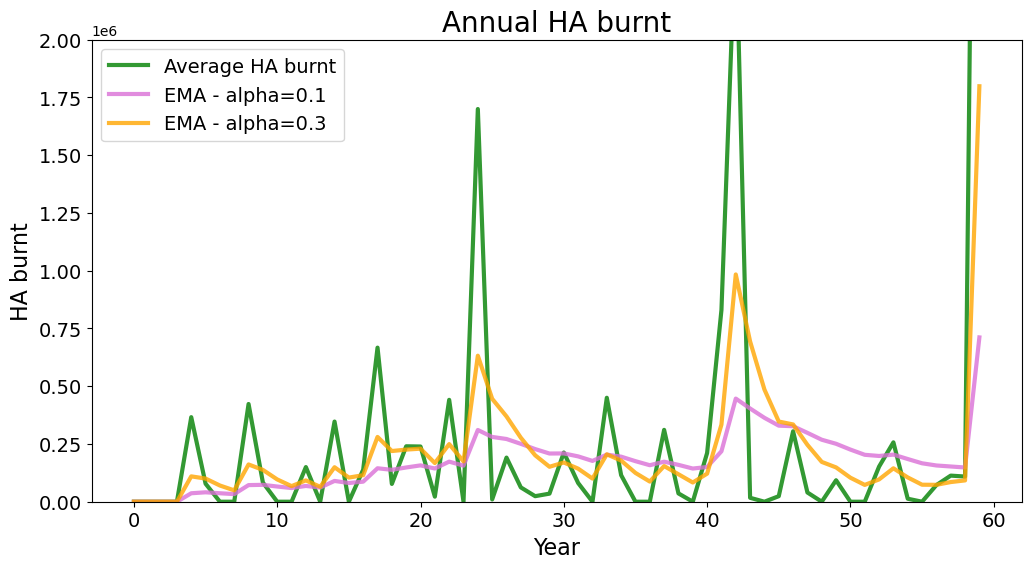

In [447]:
# colors for the line plot
colors = ['green', 'orchid', 'orange']

# line plot
df[['ha_burnt', 'EMA_0.1', 'EMA_0.3']].plot(color=colors, linewidth=3, figsize=(12,6), alpha=0.8)

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['Average HA burnt', 'EMA - alpha=0.1', 'EMA - alpha=0.3'], fontsize=14)

# title and labels
plt.title('Annual HA burnt', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('HA burnt', fontsize=16)
plt.ylim(0, 2000000)
plt.savefig("ema.png", dpi=300)

## Autoregressive integrated moving average (ARIMA)

In [463]:
df = pd.read_csv("bushfire_clean.csv")
df.head()

Unnamed: 0     Year    Aug   Sep    Oct    Nov    Dec    Jan    Feb    Mar  \
0           0  1960-61   56.9  67.8  280.3   71.6  244.9   62.6   75.0   41.0   
1           1  1961-62  239.9  52.5   74.4  517.2  172.2  133.4  158.2   62.8   
2           2  1962-63  109.7  86.5   21.9   10.4  114.1  138.7   50.4  387.8   
3           3  1963-64  269.2  24.8   62.4   41.5  279.1   18.2   37.0  171.7   
4           4  1964-65   25.7  15.1   86.3   74.2   38.0   36.8   22.7    8.4   

     Apr    May    Jun   Jul   Year.1  Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  
0   89.4   31.4   54.0  42.0  1960-61    784.1    727.2    659.4         0  
1  100.3  270.1    4.1  69.7  1961-62   1189.6    949.7    897.2         0  
2  238.6  211.1  264.8  67.2  1962-63    481.3    371.6    285.1         0  
3  139.6   78.1  407.5   9.5  1963-64    695.2    426.0    401.2         0  
4   85.1   42.6  236.3  97.8  1964-65    276.1    250.4    235.3    366000

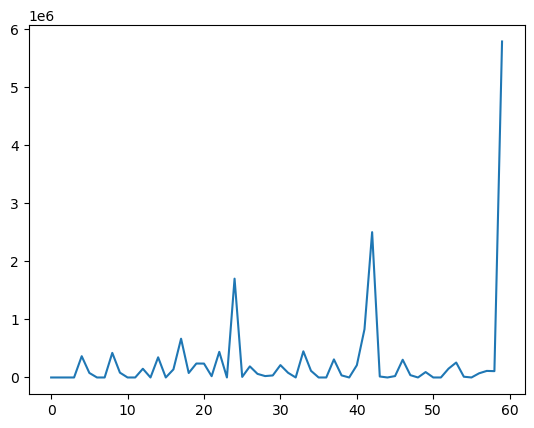

In [464]:
df.ha_burnt.plot();

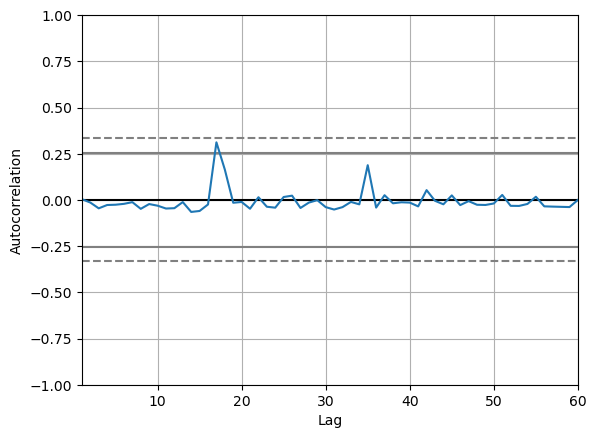

In [465]:
pd.plotting.autocorrelation_plot(df.ha_burnt);

In [771]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(df.ha_burnt, order=(2,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.savefig("residuals.png", dpi=300)
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.savefig("residualsline.png", dpi=300)
pyplot.show()
# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:               ha_burnt   No. Observations:                   60
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -891.188
Date:                Wed, 01 Dec 2021   AIC                           1788.375
Time:                        12:03:31   BIC                           1794.608
Sample:                             0   HQIC                          1790.808
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5644      0.204     -2.768      0.006      -0.964      -0.165
ar.L2         -0.2213      0.308     -0.718      0.472      -0.825       0.382
sigma2      7.976e+11   2.42e-13    3.3e+24      0.0

NameError: name 'DataFrame' is not defined

predicted=0.000000, expected=24000.000000
predicted=830696.197547, expected=305000.000000
predicted=704374.326579, expected=40000.000000
predicted=260684.742093, expected=0.000000
predicted=562624.947434, expected=93000.000000
predicted=353628.320213, expected=0.000000
predicted=505958.400651, expected=0.000000
predicted=20207.449425, expected=152000.000000
predicted=86240.468203, expected=257000.000000
predicted=230010.599704, expected=13000.000000
predicted=122798.604546, expected=0.000000
predicted=0.000000, expected=72000.000000
predicted=205000.550305, expected=113000.000000
predicted=733348.821651, expected=109000.000000
Test RMSE: 368397.834


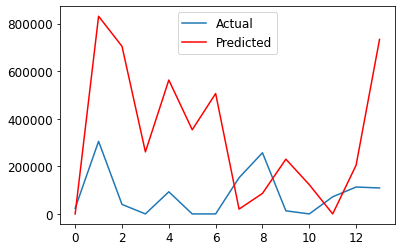

In [773]:
# split into train and test sets
warnings.filterwarnings('ignore')
X = df.ha_burnt.values[:-1]
train, test = X[0:45], X[45:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(16,1,5))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    if yhat < 0: yhat = 0
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.legend(["Actual", "Predicted"])
pyplot.savefig("arima.png", dpi=300)
pyplot.show()

In [476]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        if yhat < 0: yhat = 0
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 4, 6, 10, 12, 17]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df.ha_burnt.values[:-1], p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=548313.936
ARIMA(0, 0, 1) RMSE=579148.711
ARIMA(0, 0, 2) RMSE=607098.620
ARIMA(0, 1, 0) RMSE=680631.919
ARIMA(0, 1, 1) RMSE=607358.620
ARIMA(0, 1, 2) RMSE=628422.799
ARIMA(0, 2, 0) RMSE=962874.194
ARIMA(0, 2, 1) RMSE=696444.589
ARIMA(0, 2, 2) RMSE=713730.656
ARIMA(1, 0, 0) RMSE=588296.730
ARIMA(1, 0, 1) RMSE=585429.522
ARIMA(1, 0, 2) RMSE=597660.416
ARIMA(1, 1, 0) RMSE=731429.113
ARIMA(1, 1, 1) RMSE=630160.273
ARIMA(1, 1, 2) RMSE=642768.698
ARIMA(1, 2, 0) RMSE=859043.579
ARIMA(1, 2, 1) RMSE=760179.964
ARIMA(1, 2, 2) RMSE=729517.232
ARIMA(4, 0, 0) RMSE=595516.012
ARIMA(4, 0, 1) RMSE=597142.622
ARIMA(4, 0, 2) RMSE=619322.498
ARIMA(4, 1, 0) RMSE=701100.402
ARIMA(4, 1, 1) RMSE=629418.054
ARIMA(4, 1, 2) RMSE=638237.792
ARIMA(4, 2, 0) RMSE=835318.537
ARIMA(4, 2, 1) RMSE=750397.619
ARIMA(4, 2, 2) RMSE=715211.683
ARIMA(6, 0, 0) RMSE=590812.691
ARIMA(6, 0, 1) RMSE=589281.479
ARIMA(6, 1, 0) RMSE=700633.607
ARIMA(6, 1, 1) RMSE=642678.108
ARIMA(6, 1, 2) RMSE=643808.741
ARIMA(6,

### Seasonal autoregressive integrated moving average (SARIMA)

In [774]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

predicted=297986.398691, expected=24000.000000
predicted=270366.537498, expected=305000.000000
predicted=282074.646459, expected=40000.000000
predicted=261661.290252, expected=0.000000
predicted=216833.151012, expected=93000.000000
predicted=239379.654059, expected=0.000000
predicted=221078.077860, expected=0.000000
predicted=180161.979074, expected=152000.000000
predicted=193845.469635, expected=257000.000000
predicted=216494.554429, expected=13000.000000
predicted=181880.343100, expected=0.000000
predicted=192997.881807, expected=72000.000000
predicted=176318.061434, expected=113000.000000
predicted=203295.025427, expected=109000.000000
Test RMSE: 175593.051


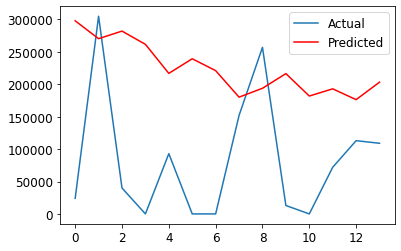

In [776]:
# split into train and test sets
X = df.ha_burnt.values[:-1]
train, test = X[0:45], X[45:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,0,1,17))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    if yhat < 0: yhat = 0
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.legend(["Actual", "Predicted"])
pyplot.savefig("sarima.png", dpi=300)
pyplot.show()

## Vector autoregression

In [498]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [504]:
df = pd.read_csv("bushfire_clean.csv")
df.drop(columns=['Unnamed: 0', 'Year.1', 'Year'], inplace=True)
df.head()

Aug   Sep    Oct    Nov    Dec    Jan    Feb    Mar    Apr    May    Jun  \
0   56.9  67.8  280.3   71.6  244.9   62.6   75.0   41.0   89.4   31.4   54.0   
1  239.9  52.5   74.4  517.2  172.2  133.4  158.2   62.8  100.3  270.1    4.1   
2  109.7  86.5   21.9   10.4  114.1  138.7   50.4  387.8  238.6  211.1  264.8   
3  269.2  24.8   62.4   41.5  279.1   18.2   37.0  171.7  139.6   78.1  407.5   
4   25.7  15.1   86.3   74.2   38.0   36.8   22.7    8.4   85.1   42.6  236.3   

    Jul  Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  
0  42.0    784.1    727.2    659.4         0  
1  69.7   1189.6    949.7    897.2         0  
2  67.2    481.3    371.6    285.1         0  
3   9.5    695.2    426.0    401.2         0  
4  97.8    276.1    250.4    235.3    366000

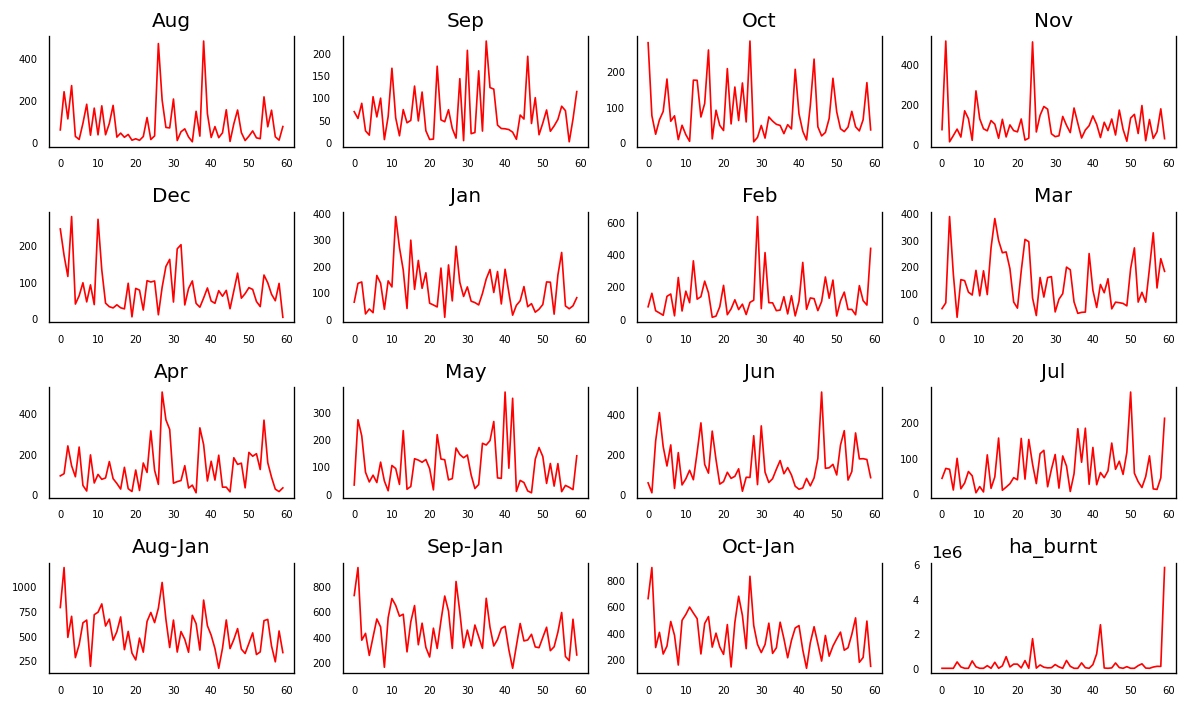

In [505]:
fig, axes = plt.subplots(nrows=4, ncols=4, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [506]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

Aug_x   Sep_x   Oct_x   Nov_x   Dec_x   Jan_x   Feb_x   Mar_x  \
Aug_y       1.0000  0.0000  0.0082  0.0000  0.3345  0.0000  0.1072  0.0000   
Sep_y       0.0000  1.0000  0.0019  0.0023  0.0000  0.0031  0.0133  0.0081   
Oct_y       0.0571  0.0060  1.0000  0.0045  0.0000  0.0125  0.0882  0.0000   
Nov_y       0.3363  0.1252  0.0000  1.0000  0.0002  0.0034  0.0000  0.0000   
Dec_y       0.0032  0.1384  0.0000  0.0000  1.0000  0.0165  0.0010  0.0447   
Jan_y       0.2847  0.0293  0.0384  0.0002  0.0001  1.0000  0.0001  0.0000   
Feb_y       0.0000  0.0000  0.0015  0.0000  0.0024  0.0250  1.0000  0.0007   
Mar_y       0.3094  0.0036  0.0043  0.2156  0.0072  0.0001  0.1662  1.0000   
Apr_y       0.0125  0.5463  0.2923  0.0000  0.1224  0.0000  0.0490  0.0948   
May_y       0.0035  0.0000  0.0147  0.1787  0.1091  0.1101  0.0003  0.1691   
Jun_y       0.0002  0.1736  0.0007  0.2890  0.0804  0.1734  0.0336  0.0001   
Jul_y       0.0185  0.0070  0.0000  0.0002  0.0072  0.0000  0.0000  0.0095   
Aug-Jan_y   0.0000  0.0063  0.0000  0.0089  0.0362  0.3722  0.1929  0.0002   
Sep-Jan_y   0.0284  0.0185  0.0000  0.0396  0.0201  0.0225  0.1539  0.0000   
Oct-Jan_y   0.0219  0.4613  0.0015  0.0759  0.0416  0.0016  0.0016  0.0000   
ha_burnt_y  0.1417  0.4535  0.1631  0.2933  0.6427  0.0012  0.5451  0.0003   

             Apr_x   May_x   Jun_x   Jul_x  Aug-Jan_x  Sep-Jan_x  Oct-Jan_x  \
Aug_y       0.0003  0.1580  0.0000  0.4529     0.0001     0.0001     0.0172   
Sep_y       0.0000  0.0324  0.4947  0.0673     0.0070     0.0005     0.0005   
Oct_y       0.0000  0.0978  0.0710  0.0000     0.1867     0.0000     0.0105   
Nov_y       0.2908  0.1028  0.0590  0.0054     0.0693     0.0028     0.0000   
Dec_y       0.0000  0.1501  0.3941  0.0012     0.0404     0.0047     0.0002   
Jan_y       0.0000  0.0136  0.0340  0.0003     0.0198     0.0211     0.0067   
Feb_y       0.0652  0.0024  0.0284  0.1830     0.0021     0.0206     0.0169   
Mar_y       0.0894  0.0181  0.0002  0.0056     0.0161     0.0082     0.0698   
Apr_y       1.0000  0.5926  0.2028  0.0000     0.0462     0.2578     0.1524   
May_y       0.0078  1.0000  0.0001  0.0125     0.0034     0.0267     0.0304   
Jun_y       0.0074  0.0176  1.0000  0.1743     0.0119     0.0375     0.0072   
Jul_y       0.2361  0.0000  0.0068  1.0000     0.0003     0.0000     0.0000   
Aug-Jan_y   0.0600  0.2472  0.0000  0.0834     1.0000     0.0000     0.0000   
Sep-Jan_y   0.0010  0.2350  0.2222  0.0665     0.0284     1.0000     0.0185   
Oct-Jan_y   0.0000  0.1693  0.1447  0.0570     0.0305     0.4613     1.0000   
ha_burnt_y  0.0011  0.3251  0.0267  0.0000     0.2164     0.2874     0.3350   

            ha_burnt_x  
Aug_y           0.0001  
Sep_y           0.0062  
Oct_y           0.1048  
Nov_y           0.5410  
Dec_y           0.1401  
Jan_y           0.0206  
Feb_y           0.0001  
Mar_y           0.0001  
Apr_y           0.0300  
May_y           0.0696  
Jun_y           0.0000  
Jul_y           0.0425  
Aug-Jan_y       0.1232  
Sep-Jan_y       0.4521  
Oct-Jan_y       0.0644  
ha_burnt_y      1.0000

In [522]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Aug    ::  3276.69   > nan       =>   False
Sep    ::  2721.02   > nan       =>   False
Oct    ::  2237.2    > nan       =>   False
Nov    ::  1803.35   > nan       =>   False
Dec    ::  1416.52   > 311.1288  =>   True
Jan    ::  1079.62   > 263.2603  =>   True
Feb    ::  758.99    > 219.4051  =>   True
Mar    ::  515.34    > 179.5199  =>   True
Apr    ::  323.11    > 143.6691  =>   True
May    ::  201.42    > 111.7797  =>   True
Jun    ::  116.23    > 83.9383   =>   True
Jul    ::  68.51     > 60.0627   =>   True
Aug-Jan ::  32.81     > 40.1749   =>   False
Sep-Jan ::  12.15     > 24.2761   =>   False
Oct-Jan ::  2.9       > 12.3212   =>   False
ha_burnt ::  0.15      > 4.1296    =>   False


In [508]:
nobs = 15
df_train, df_test = df[0:-nobs], df[-nobs:]

In [509]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [510]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Aug" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4658
 No. Lags Chosen       = 0
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Sep" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8993
 No. Lags Chosen       = 0
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Oct" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [518]:
model = VAR(df)
for i in [2,5,6,8,9,12,15,17]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 2
AIC :  120.7613113866863
BIC :  139.51844775855716
FPE :  3.2842680545198643e+53
HQIC:  128.0675948390721 

Lag Order = 5
AIC :  -706.0673516755033
BIC :  -658.7672824380255
FPE :  0.0
HQIC:  -687.776032811036 

Lag Order = 6
AIC :  -688.0975746949698
BIC :  -630.9326998751966
FPE :  0.0
HQIC:  -666.0513242445186 

Lag Order = 8
AIC :  -673.6255035560469
BIC :  -596.1761374954301
FPE :  0.0
HQIC:  -643.933244521347 

Lag Order = 9
AIC :  -664.4819729801745
BIC :  -576.6028461582052
FPE :  0.0
HQIC:  -630.9007594505421 

Lag Order = 12
AIC :  -624.8780142760264
BIC :  -504.4974159076187
FPE :  0.0
HQIC:  -579.3860103139813 

Lag Order = 15
AIC :  -592.3392703532056
BIC :  -437.5283690075533
FPE :  0.0
HQIC:  -534.6273206923905 

Lag Order = 17
AIC :  -566.2148485079106
BIC :  -387.3096832672249
FPE :  0.0
HQIC:  -500.2401526736518 



In [520]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Nov, 2021
Time:                     18:29:16
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -658.767
Nobs:                     55.0000    HQIC:                  -687.776
Log likelihood:           19464.2    FPE:                    0.00000
AIC:                     -706.067    Det(Omega_mle):    1.23516e-322
--------------------------------------------------------------------
Results for equation Aug
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.001175         0.002058           -0.571           0.568
L1.Aug             -0.370459              NAN              NAN             NAN
L1.Sep              0.436263              NAN              NAN        

In [523]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Aug    : 2.58
Sep    : 1.68
Oct    : 1.75
Nov    : 2.75
Dec    : 0.81
Jan    : 1.7
Feb    : 2.41
Mar    : 2.12
Apr    : 2.17
May    : 1.46
Jun    : 2.64
Jul    : 2.39
Aug-Jan : 1.83
Sep-Jan : 1.29
Oct-Jan : 2.63
ha_burnt : 2.6


In [525]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df.values[-lag_order:]
forecast_input

5


array([[7.180e+01, 8.000e+01, 4.300e+01, 1.226e+02, 9.660e+01, 2.498e+02, 2.580e+01, 1.932e+02, 1.550e+02, 7.200e+00, 3.050e+02, 1.046e+02, 6.638e+02, 5.920e+02, 5.120e+02, 0.000e+00],
       [1.514e+02, 7.000e+01, 3.140e+01, 2.720e+01, 6.500e+01, 4.840e+01, 2.052e+02, 3.266e+02, 8.260e+01, 3.000e+01, 1.746e+02, 1.260e+01, 3.934e+02, 2.420e+02, 1.720e+02, 7.200e+04],
       [2.420e+01, 2.000e-01, 6.280e+01, 6.120e+01, 4.720e+01, 3.780e+01, 1.128e+02, 1.188e+02, 2.320e+01, 2.320e+01, 1.756e+02, 1.120e+01, 2.334e+02, 2.092e+02, 2.090e+02, 1.130e+05],
       [7.800e+00, 5.100e+01, 1.676e+02, 1.762e+02, 9.500e+01, 4.880e+01, 8.540e+01, 2.292e+02, 1.120e+01, 1.460e+01, 1.714e+02, 4.340e+01, 5.464e+02, 5.386e+02, 4.876e+02, 1.090e+05],
       [7.300e+01, 1.128e+02, 3.420e+01, 2.620e+01, 1.600e+00, 7.940e+01, 4.344e+02, 1.814e+02, 2.960e+01, 1.382e+02, 8.020e+01, 2.092e+02, 3.272e+02, 2.542e+02, 1.414e+02, 5.780e+06]])

In [526]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

Aug_2d        Sep_2d        Oct_2d        Nov_2d        Dec_2d  \
45 -2.367796e+02 -2.195835e+02  6.316982e+02  5.072235e+01  3.366117e+02   
46  6.217619e+02  5.515924e+00  9.955619e+01  1.248459e+03 -4.008321e+02   
47 -1.673305e+03 -3.309328e+02  1.360190e+03 -1.320421e+03  4.726861e+02   
48  3.221045e+03  7.791678e+02 -1.697058e+03  2.668573e+03 -1.339856e+03   
49 -6.032603e+03 -1.957543e+03  5.101202e+03 -3.584989e+03  3.033829e+03   
50  1.199035e+04  3.998878e+03 -8.424523e+03  9.081193e+03 -5.714055e+03   
51 -2.418098e+04 -8.023477e+03  1.761232e+04 -1.845332e+04  1.121030e+04   
52  4.853736e+04  1.591872e+04 -3.359008e+04  3.726068e+04 -2.196164e+04   
53 -9.630604e+04 -3.143628e+04  6.774849e+04 -7.171140e+04  4.451945e+04   
54  1.895275e+05  6.263288e+04 -1.347554e+05  1.421048e+05 -8.730017e+04   
55 -3.763404e+05 -1.240645e+05  2.679865e+05 -2.819219e+05  1.738596e+05   
56  7.465961e+05  2.461234e+05 -5.297608e+05  5.614596e+05 -3.438781e+05   
57 -1.481988e+06 -4.876613e+05  1.050877e+06 -1.112277e+06  6.828876e+05   
58  2.938366e+06  9.676374e+05 -2.082862e+06  2.205555e+06 -1.353331e+06   
59 -5.824922e+06 -1.919109e+06  4.133054e+06 -4.368909e+06  2.684182e+06   

          Jan_2d        Feb_2d        Mar_2d        Apr_2d        May_2d  \
45  3.868752e+02 -4.476598e+02  1.196942e+03 -7.661812e+02 -5.092734e+02   
46 -3.698711e+02  1.141201e+03 -7.513105e+02  1.694864e+03  1.088413e+03   
47  1.334491e+03 -1.675791e+03  2.780094e+03 -2.952906e+03 -2.375622e+03   
48 -2.217466e+03  3.879928e+03 -3.294591e+03  5.619902e+03  4.697013e+03   
49  5.085560e+03 -7.037509e+03  8.714806e+03 -9.943688e+03 -9.723291e+03   
50 -8.801484e+03  1.479687e+04 -1.576817e+04  2.272177e+04  1.872426e+04   
51  1.847294e+04 -2.728401e+04  3.350879e+04 -4.447358e+04 -3.811775e+04   
52 -3.670736e+04  5.478494e+04 -6.404071e+04  8.968520e+04  7.535220e+04   
53  7.366660e+04 -1.079614e+05  1.284555e+05 -1.742963e+05 -1.502910e+05   
54 -1.451483e+05  2.163901e+05 -2.525237e+05  3.468115e+05  2.967762e+05   
55  2.877823e+05 -4.274878e+05  5.035364e+05 -6.880593e+05 -5.891699e+05   
56 -5.704654e+05  8.467692e+05 -9.961553e+05  1.367001e+06  1.167904e+06   
57  1.132736e+06 -1.678022e+06  1.977987e+06 -2.709043e+06 -2.316610e+06   
58 -2.244840e+06  3.328203e+06 -3.917515e+06  5.369843e+06  4.592652e+06   
59  4.451952e+06 -6.599680e+06  7.771597e+06 -1.064484e+07 -9.106794e+06   

           Jun_2d        Jul_2d     Aug-Jan_2d    Sep-Jan_2d    Oct-Jan_2d  \
45    -109.270380 -7.312427e+01     949.544341  1.186324e+03  1.405907e+03   
46     238.428690  7.200853e+02    1204.589690  5.828278e+02  5.773119e+02   
47     618.351501 -1.148127e+03    -157.291123  1.516014e+03  1.846947e+03   
48     389.459351  2.682648e+03    1414.405315 -1.806640e+03 -2.585807e+03   
49     537.000327 -4.221367e+03    1645.456308  7.678059e+03  9.635602e+03   
50    1634.722636  8.877063e+03    2130.362397 -9.859991e+03 -1.385887e+04   
51    -466.847342 -1.748423e+04   -3362.207503  2.081877e+04  2.884225e+04   
52    3642.748840  3.549038e+04    9457.683872 -3.907968e+04 -5.499840e+04   
53   -3995.731588 -6.977223e+04  -13519.175669  8.278686e+04  1.142231e+05   
54   10878.882737  1.381176e+05   27061.368890 -1.624661e+05 -2.250990e+05   
55  -20274.426637 -2.733839e+05  -52698.369574  3.236420e+05  4.477066e+05   
56   42051.348363  5.427348e+05  110074.875564 -6.365212e+05 -8.826447e+05   
57  -81034.624706 -1.076412e+06 -215426.693952  1.266561e+06  1.754223e+06   
58  161841.028487  2.135189e+06  430525.813050 -2.507840e+06 -3.475477e+06   
59 -320443.598706 -4.232145e+06 -843753.229571  4.981169e+06  6.900279e+06   

     ha_burnt_2d  
45 -6.614022e+06  
46  1.576217e+07  
47 -2.607120e+07  
48  5.901555e+07  
49 -1.167792e+08  
50  2.331370e+08  
51 -4.620393e+08  
52  9.121619e+08  
53 -1.813122e+09  
54  3.597282e+09  
55 -7.135612e+09  
56  1.414484e+10  
57 -2.803989e+10  
58  5.560406e+10  
59 -1.102496e+11

In [527]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [532]:
df_results.columns

Index(['Aug_2d', 'Sep_2d', 'Oct_2d', 'Nov_2d', 'Dec_2d', 'Jan_2d', 'Feb_2d',
       'Mar_2d', 'Apr_2d', 'May_2d', 'Jun_2d', 'Jul_2d', 'Aug-Jan_2d',
       'Sep-Jan_2d', 'Oct-Jan_2d', 'ha_burnt_2d', 'Aug_1d', 'Aug_forecast',
       'Sep_1d', 'Sep_forecast', 'Oct_1d', 'Oct_forecast', 'Nov_1d',
       'Nov_forecast', 'Dec_1d', 'Dec_forecast', 'Jan_1d', 'Jan_forecast',
       'Feb_1d', 'Feb_forecast', 'Mar_1d', 'Mar_forecast', 'Apr_1d',
       'Apr_forecast', 'May_1d', 'May_forecast', 'Jun_1d', 'Jun_forecast',
       'Jul_1d', 'Jul_forecast', 'Aug-Jan_1d', 'Aug-Jan_forecast',
       'Sep-Jan_1d', 'Sep-Jan_forecast', 'Oct-Jan_1d', 'Oct-Jan_forecast',
       'ha_burnt_1d', 'ha_burnt_forecast'],
      dtype='object')

In [534]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.drop(columns=['Aug_2d', 'Sep_2d', 'Oct_2d', 'Nov_2d', 'Dec_2d', 'Jan_2d', 'Feb_2d',
       'Mar_2d', 'Apr_2d', 'May_2d', 'Jun_2d', 'Jul_2d', 'Aug-Jan_2d',
       'Sep-Jan_2d', 'Oct-Jan_2d', 'ha_burnt_2d', 'Aug_1d', 'Sep_1d', 
       'Oct_1d', 'Nov_1d', 'Dec_1d', 'Jan_1d', 'Feb_1d',
       'Mar_1d', 'Apr_1d', 'May_1d', 'Jun_1d', 'Jul_1d', 'Aug-Jan_1d',
       'Sep-Jan_1d', 'Oct-Jan_1d', 'ha_burnt_1d'], inplace=True)
df_results

Aug_forecast   Sep_forecast  Oct_forecast  Nov_forecast  Dec_forecast  \
45  2.702042e+01    -104.983535  9.968982e+02  7.552235e+01  4.286117e+02   
46  5.224027e+02    -264.651146  1.859353e+03  1.332704e+03  3.805913e+02   
47 -6.555198e+02    -755.251584  4.081997e+03  1.269464e+03  8.052569e+02   
48  1.387603e+03    -466.684222  4.607584e+03  3.874798e+03 -1.099339e+02   
49 -2.601878e+03   -2135.659968  1.023437e+04  2.895143e+03  2.008704e+03   
50  5.398995e+03     194.242784  7.436638e+03  1.099668e+04 -1.586713e+03   
51 -1.078111e+04   -5499.331236  2.225122e+04  6.448970e+02  6.028173e+03   
52  2.157615e+04    4725.816957  3.475730e+03  2.755379e+04 -8.318583e+03   
53 -4.237263e+04  -16485.314124  5.244873e+04 -1.724871e+04  2.185411e+04   
54  8.320605e+04   24936.433762 -3.333366e+04  8.005362e+04 -3.527336e+04   
55 -1.675556e+05  -57706.354883  1.488704e+05 -1.045659e+05  8.145880e+04   
56  3.282787e+05  105774.295858 -1.986862e+05  2.722741e+05 -1.456871e+05   
57 -6.578747e+05 -218406.372824  5.046337e+05 -4.631631e+05  3.100546e+05   
58  1.294338e+06  425050.358989 -8.749080e+05  1.006954e+06 -5.875346e+05   
59 -2.578372e+06 -850602.381216  1.878604e+06 -1.891837e+06  1.199058e+06   

    Jan_forecast  Feb_forecast  Mar_forecast  Apr_forecast  May_forecast  \
45  4.716752e+02 -3.270598e+02  1.403342e+03 -7.325812e+02 -4.204734e+02   
46  5.056794e+02  3.620815e+02  1.901774e+03  1.963014e+02  1.990665e+02   
47  1.874174e+03 -6.245687e+02  5.180299e+03 -1.827722e+03 -1.557016e+03   
48  1.025203e+03  2.268709e+03  5.164233e+03  1.768156e+03  1.383914e+03   
49  5.261792e+03 -1.875523e+03  1.386297e+04 -4.579653e+03 -5.398446e+03   
50  6.968971e+02  8.777117e+03  6.793540e+03  1.179430e+04  6.543451e+03   
51  1.460495e+04 -7.854253e+03  3.323289e+04 -1.630532e+04 -1.963240e+04   
52 -8.194364e+03  3.029932e+04 -4.368459e+03  4.528026e+04  2.954396e+04   
53  4.267293e+04 -3.950853e+04  8.648570e+04 -6.743046e+04 -7.157066e+04   
54 -5.160803e+04  1.070737e+05 -7.518388e+04  1.666704e+05  1.240909e+05   
55  1.418933e+05 -1.738319e+05  2.666830e+05 -2.872882e+05 -2.694174e+05   
56 -2.350707e+05  3.920316e+05 -3.876055e+05  6.257540e+05  5.049783e+05   
57  5.207008e+05 -7.201265e+05  9.360925e+05 -1.170247e+06 -1.037236e+06   
58 -9.683673e+05  1.495918e+06 -1.657725e+06  2.403596e+06  2.013202e+06   
59  1.994516e+06 -2.887718e+06  3.520056e+06 -4.667402e+06 -4.043154e+06   

     Jun_forecast  Jul_forecast  Aug-Jan_forecast  Sep-Jan_forecast  \
45       9.729620  8.675727e+00       1894.744341      1.867724e+03   
46     178.887931  6.746367e+02       4336.078372      3.813676e+03   
47     966.397742  1.924712e+02       6620.121280      7.275641e+03   
48    2143.366904  2.392954e+03      10318.569502      8.930967e+03   
49    3857.336393  3.720697e+02      15662.474033      1.826435e+04   
50    7206.028519  7.228248e+03      23136.740961      1.773775e+04   
51   10087.873302 -3.399803e+03      27248.800385      3.802991e+04   
52   16612.466924  2.146252e+04      40818.543682      1.924240e+04   
53   19141.328959 -2.344738e+04      40869.111309      8.324174e+04   
54   32549.073730  6.976033e+04      67981.047826     -1.522500e+04   
55   25682.391865 -1.104159e+05      42394.614769      2.099503e+05   
56   60867.058363  2.521427e+05     126883.057276     -2.013957e+05   
57   15017.100154 -4.617106e+05      -4055.194170      6.538195e+05   
58  131008.170434  9.596255e+05     295532.367435     -9.988052e+05   
59  -73444.357993 -1.851183e+06    -248633.300530      2.329739e+06   

    Oct-Jan_forecast  ha_burnt_forecast  
45      1.972707e+03      -6.631022e+06  
46      4.078327e+03       2.500126e+06  
47      8.030893e+03      -1.443993e+07  
48      9.397651e+03       2.763557e+07  
49      2.040001e+04      -4.706817e+07  
50      1.754350e+04       1.113651e+08  
51      4.352924e+04      -1.922410e+08  
52      1.451658e+04       4.163148e+08  
53      9.972706e+04      -7.882513e+08

In [536]:
cols = df_results.columns
for col in cols:
    df_results[col] = [max(0, x) for x in df_results[col]]
df_results.head()

Aug_forecast  Sep_forecast  Oct_forecast  Nov_forecast  Dec_forecast  \
45     27.020418           0.0    996.898160     75.522352    428.611696   
46    522.402736           0.0   1859.352509   1332.703625    380.591253   
47      0.000000           0.0   4081.997234   1269.464393    805.256892   
48   1387.602518           0.0   4607.583698   3874.798267      0.000000   
49      0.000000           0.0  10234.372414   2895.143298   2008.703961   

    Jan_forecast  Feb_forecast  Mar_forecast  Apr_forecast  May_forecast  \
45    471.675250      0.000000   1403.342247      0.000000      0.000000   
46    505.679394    362.081506   1901.774018    196.301414    199.066541   
47   1874.174191      0.000000   5180.299319      0.000000      0.000000   
48   1025.203177   2268.708793   5164.233427   1768.156119   1383.914424   
49   5261.792188      0.000000  13862.973574      0.000000      0.000000   

    Jun_forecast  Jul_forecast  Aug-Jan_forecast  Sep-Jan_forecast  \
45      9.729620      8.675727       1894.744341       1867.723923   
46    178.887931    674.636719       4336.078372       3813.675636   
47    966.397742    192.471196       6620.121280       7275.641124   
48   2143.366904   2392.953841      10318.569502       8930.966984   
49   3857.336393    372.069690      15662.474033      18264.351893   

    Oct-Jan_forecast  ha_burnt_forecast  
45       1972.707458       0.000000e+00  
46       4078.326782       2.500126e+06  
47       8030.892709       0.000000e+00  
48       9397.651205       2.763557e+07  
49      20400.011861       0.000000e+00

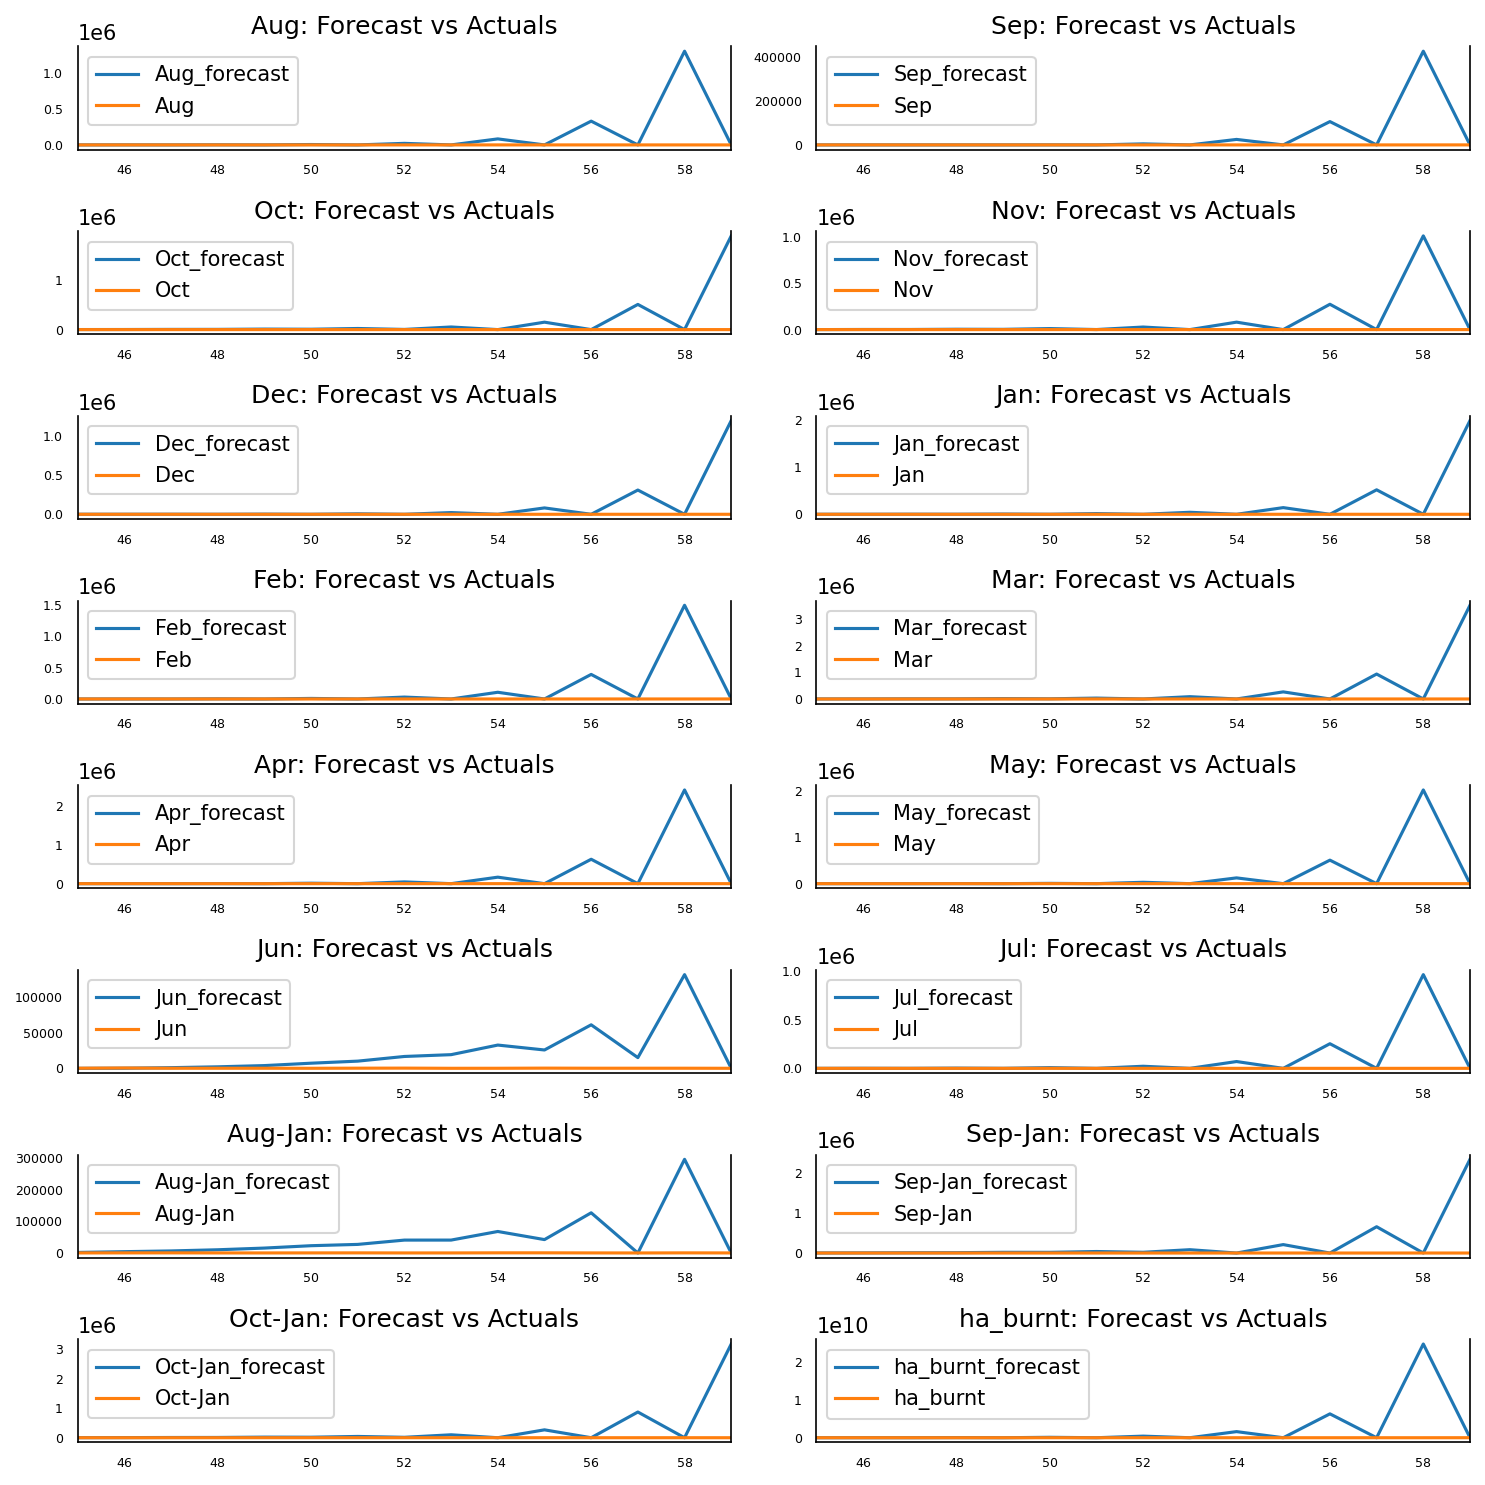

In [537]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [543]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: ha_burnt')
accuracy_prod = forecast_accuracy(df_results['ha_burnt_forecast'].values, 
                                  df_test['ha_burnt'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: ha_burnt
mape   :  inf
me     :  2200701946.1839
mae    :  2201542879.5173
mpe    :  inf
rmse   :  6566263995.7116
corr   :  -0.0916
minmax :  nan


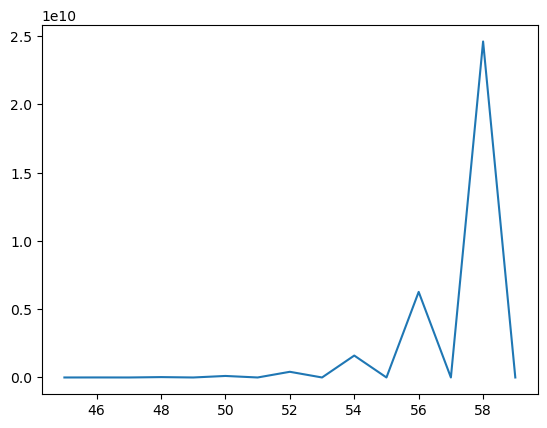

In [545]:
plt.plot(df_results['ha_burnt_forecast'])

# LSTM for multivariate time series

In [5]:
import pandas as pd
df = pd.read_csv("bushfire_clean.csv")

RMSE: 134080.573


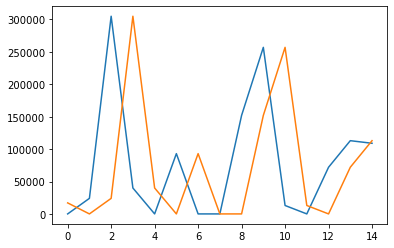

In [7]:
# persistence model forecast
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# split data into train and test
X = df.ha_burnt.values[:-1]
train, test = X[0:-15], X[-15:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

In [9]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# transform to supervised learning
X = df.ha_burnt.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

     0       0
0  0.0       0
1  0.0       0
2  0.0       0
3  0.0       0
4  0.0  366000


In [10]:
from pandas import Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

series = df.ha_burnt.to_list()
 
# transform to be stationary
differenced = difference(series, 1)
# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

0         0
1         0
2         0
3    366000
4     78000
dtype: int64


In [12]:
from sklearn.preprocessing import MinMaxScaler

# transform scale
X = df.ha_burnt.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

0   -1.000000
1   -1.000000
2   -1.000000
3   -1.000000
4   -0.873356
dtype: float64
0         0.0
1         0.0
2         0.0
3         0.0
4    366000.0
dtype: float64


In [13]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# transform data to be stationary
series = df.ha_burnt
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

## Pytorch LSTM (univariate)

In [24]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
df = pd.read_csv("bushfire_clean.csv")
series = df.ha_burnt.values.astype(float)

def initial_data_plot(series):
    plt.ylabel('HA Burnt')
    plt.xlabel('Time period')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(series);
    
def train_test_split(series, test_data_size=15):
    train_data = series[:-test_data_size]
    test_data = series[-test_data_size:]
    return train_data, test_data

def scale_data(train_data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
    return train_data_normalized

def create_inout_sequences(input_data, tw=15):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
def train(train_inout_seq):
    epochs = 150
    for i in range(epochs):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    
def create_test_inputs(train_data_normalized, fut_pred=12):
    test_inputs = train_data_normalized[-train_window:].tolist()
    return test_inputs

train_data, test_data = train_test_split(series)
train_data_normalized = scale_data(train_data)
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(train_inout_seq)

test_inputs = create_test_inputs(train_data_normalized)

model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

epoch:   1 loss: 0.08062099
epoch:  26 loss: 0.04854310
epoch:  51 loss: 0.01328437
epoch:  76 loss: 0.00061997
epoch: 101 loss: 0.00003573
epoch: 126 loss: 0.00315451
epoch: 149 loss: 0.0021354349
[[-68.17627048]
 [-39.29085469]
 [-56.46548009]
 [ 12.47420067]
 [-29.09263438]
 [-39.11308235]
 [-45.98832941]
 [-46.13740867]
 [-21.89975655]
 [-29.75056833]
 [ 74.96246749]
 [117.8021037 ]]


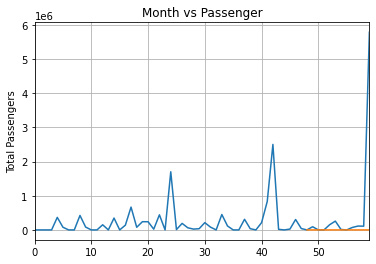

In [44]:
x = np.arange(48, 60, 1)

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(series)
plt.plot(x,actual_predictions)
plt.show()

In [46]:
actual_predictions

array([[-20.35545594],
       [138.32278156],
       [ 32.72714877],
       [ 31.19421148],
       [ 47.17541629],
       [ 44.01893342],
       [ 43.86524373],
       [ 49.1587373 ],
       [ 57.52122426],
       [ 58.27462101],
       [ 42.93610865],
       [ 45.1288783 ]])

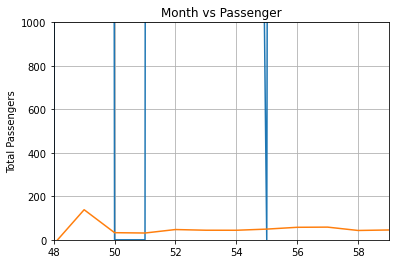

In [48]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(x,series[-train_window:])
plt.plot(x,actual_predictions)
plt.ylim(0, 1000)
plt.show()

# Trying LSTM again

In [781]:
df = pd.read_csv("bushfire_clean.csv")
df.drop(['Year.1', 'Year', 'Unnamed: 0'], axis=1, inplace=True)
df.head()

Aug   Sep    Oct    Nov    Dec    Jan    Feb    Mar    Apr    May    Jun  \
0   56.9  67.8  280.3   71.6  244.9   62.6   75.0   41.0   89.4   31.4   54.0   
1  239.9  52.5   74.4  517.2  172.2  133.4  158.2   62.8  100.3  270.1    4.1   
2  109.7  86.5   21.9   10.4  114.1  138.7   50.4  387.8  238.6  211.1  264.8   
3  269.2  24.8   62.4   41.5  279.1   18.2   37.0  171.7  139.6   78.1  407.5   
4   25.7  15.1   86.3   74.2   38.0   36.8   22.7    8.4   85.1   42.6  236.3   

    Jul  Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  
0  42.0    784.1    727.2    659.4         0  
1  69.7   1189.6    949.7    897.2         0  
2  67.2    481.3    371.6    285.1         0  
3   9.5    695.2    426.0    401.2         0  
4  97.8    276.1    250.4    235.3    366000

Let's feature-engineer the data. Basically, we'll keep the Dennison index, and then add anything we can think of that might help jig out the underlying bushfire index patterns.

In [782]:
df.drop(columns=['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 
                 'Mar', 'Apr', 'May', 'Jun', 'Jul'], inplace=True)
df.head()

Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt
0    784.1    727.2    659.4         0
1   1189.6    949.7    897.2         0
2    481.3    371.6    285.1         0
3    695.2    426.0    401.2         0
4    276.1    250.4    235.3    366000

In [783]:
# exponential moving average HA burnt
df['EMA_ha_burnt'] = df.ha_burnt.ewm(alpha=0.1, adjust=False).mean()
# simple moving average HA burnt
df['SMA_ha_burnt'] = df.ha_burnt.rolling(15, min_periods=1).mean()
# exponential moving standard deviation HA burnt
df['EMA_ha_burnt_std'] = df.ha_burnt.ewm(alpha=0.1, adjust=False).std()
# total burnt in last 15 years
df['sum_ha_burnt_15'] = df.ha_burnt.rolling(15, min_periods=1).sum()

# exponential moving average Dennison index (Oct-Jan)
df['EMA_Oct-Jan'] = df['Oct-Jan'].ewm(alpha=0.4, adjust=False).mean()
# simple moving average Dennison index
df['SMA_Oct-Jan'] = df['Oct-Jan'].rolling(15, min_periods=1).mean()
# exponential moving standard deviation Dennison index
df['EMA_Oct-Jan_std'] = df['Oct-Jan'].ewm(alpha=0.4, adjust=False).std()
# total rain in last 15 years
df['sum_Oct-Jan'] = df['Oct-Jan'].rolling(15, min_periods=1).sum()

Since there seems to be a big fire every 15-20 years, I want to somehow encode this in the data.

In [784]:
def years_since_million(df):
    lst = []
    count = 0
    for i in range(len(df)):
        lst.append(count)
        if df.ha_burnt.iloc[i] > 1000000:
            count = 0
        else:
            count+=1
    return lst

df['years_since_million'] = years_since_million(df)
df.head()

Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  EMA_ha_burnt  SMA_ha_burnt  \
0    784.1    727.2    659.4         0           0.0           0.0   
1   1189.6    949.7    897.2         0           0.0           0.0   
2    481.3    371.6    285.1         0           0.0           0.0   
3    695.2    426.0    401.2         0           0.0           0.0   
4    276.1    250.4    235.3    366000       36600.0       73200.0   

   EMA_ha_burnt_std  sum_ha_burnt_15  EMA_Oct-Jan  SMA_Oct-Jan  \
0               NaN              0.0    659.40000      659.400   
1          0.000000              0.0    754.52000      778.300   
2          0.000000              0.0    566.75200      613.900   
3          0.000000              0.0    500.53120      560.725   
4     149480.148816         366000.0    394.43872      495.640   

   EMA_Oct-Jan_std  sum_Oct-Jan  years_since_million  
0              NaN        659.4                    0  
1       168.149993       1556.6                    1  
2       305.756319       1841.7                    2  
3       245.787638       2242.9                    3  
4       240.918888       2478.2                    4

In [785]:
df = df.fillna(0)
df.head()

Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  EMA_ha_burnt  SMA_ha_burnt  \
0    784.1    727.2    659.4         0           0.0           0.0   
1   1189.6    949.7    897.2         0           0.0           0.0   
2    481.3    371.6    285.1         0           0.0           0.0   
3    695.2    426.0    401.2         0           0.0           0.0   
4    276.1    250.4    235.3    366000       36600.0       73200.0   

   EMA_ha_burnt_std  sum_ha_burnt_15  EMA_Oct-Jan  SMA_Oct-Jan  \
0          0.000000              0.0    659.40000      659.400   
1          0.000000              0.0    754.52000      778.300   
2          0.000000              0.0    566.75200      613.900   
3          0.000000              0.0    500.53120      560.725   
4     149480.148816         366000.0    394.43872      495.640   

   EMA_Oct-Jan_std  sum_Oct-Jan  years_since_million  
0         0.000000        659.4                    0  
1       168.149993       1556.6                    1  
2       305.756319       1841.7                    2  
3       245.787638       2242.9                    3  
4       240.918888       2478.2                    4

In [821]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

df = df.astype(float)

# split the data intro train and test
df_train, df_test = df.iloc[:45], df.iloc[45:]
X_train, y_train = df_train.drop(columns=['ha_burnt']), df_train.ha_burnt
X_test, y_test = df_test.drop(columns=['ha_burnt']), df_test.ha_burnt

# train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# get the predictions (clamp at 0)
y_pred = model.predict(X_test)
y_pred = [max(0, x) for x in y_pred]
rmse = np.sqrt(mse(y_pred, y_test))
rmse

1155211.7072063747

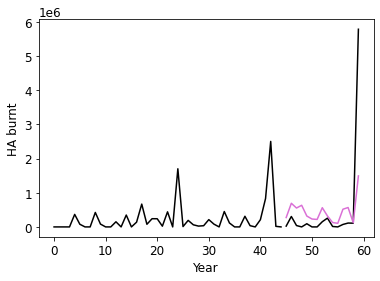

In [822]:
x = [x for x in range(45, 60, 1)]
plt.plot(y_train, color="black")
plt.plot(y_test, color="black")
plt.plot(x, y_pred, color="orchid")
plt.xlabel('Year')
plt.ylabel('HA burnt')
plt.savefig("feature.png", dpi=300)
plt.show()

In [823]:
rmse = np.sqrt(mse(y_pred[:-1], y_test[:-1]))
rmse

341027.2755115889

### Classification model

In [864]:
df.head()

Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  EMA_ha_burnt  SMA_ha_burnt  \
0    784.1    727.2    659.4       0.0           0.0           0.0   
1   1189.6    949.7    897.2       0.0           0.0           0.0   
2    481.3    371.6    285.1       0.0           0.0           0.0   
3    695.2    426.0    401.2       0.0           0.0           0.0   
4    276.1    250.4    235.3  366000.0       36600.0       73200.0   

   EMA_ha_burnt_std  sum_ha_burnt_15  EMA_Oct-Jan  SMA_Oct-Jan  \
0          0.000000              0.0    659.40000      659.400   
1          0.000000              0.0    754.52000      778.300   
2          0.000000              0.0    566.75200      613.900   
3          0.000000              0.0    500.53120      560.725   
4     149480.148816         366000.0    394.43872      495.640   

   EMA_Oct-Jan_std  sum_Oct-Jan  years_since_million  
0         0.000000        659.4                  0.0  
1       168.149993       1556.6                  1.0  
2       305.756319       1841.7                  2.0  
3       245.787638       2242.9                  3.0  
4       240.918888       2478.2                  4.0

In [865]:
df['severe'] = np.where(df['ha_burnt'] > 1000000, 1, 0)
df.head()

Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  EMA_ha_burnt  SMA_ha_burnt  \
0    784.1    727.2    659.4       0.0           0.0           0.0   
1   1189.6    949.7    897.2       0.0           0.0           0.0   
2    481.3    371.6    285.1       0.0           0.0           0.0   
3    695.2    426.0    401.2       0.0           0.0           0.0   
4    276.1    250.4    235.3  366000.0       36600.0       73200.0   

   EMA_ha_burnt_std  sum_ha_burnt_15  EMA_Oct-Jan  SMA_Oct-Jan  \
0          0.000000              0.0    659.40000      659.400   
1          0.000000              0.0    754.52000      778.300   
2          0.000000              0.0    566.75200      613.900   
3          0.000000              0.0    500.53120      560.725   
4     149480.148816         366000.0    394.43872      495.640   

   EMA_Oct-Jan_std  sum_Oct-Jan  years_since_million  severe  
0         0.000000        659.4                  0.0       0  
1       168.149993       1556.6                  1.0       0  
2       305.756319       1841.7                  2.0       0  
3       245.787638       2242.9                  3.0       0  
4       240.918888       2478.2                  4.0       0

In [871]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = df.astype(float)
#df.drop(columns=['ha_burnt'], inplace=True)

# split the data intro train and test
df_train, df_test = df.iloc[:45], df.iloc[45:]
X_train, y_train = df_train.drop(columns=['severe']), df_train.severe
X_test, y_test = df_test.drop(columns=['severe']), df_test.severe

# train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# get the predictions (clamp at 0)
y_pred = model.predict(X_test)
y_pred = [max(0, x) for x in y_pred]
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.9333333333333333

In [872]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)

array([[14,  1],
       [ 0,  0]])

### Sensitivity analysis

In [807]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
import math

len(df.columns)

13

In [806]:
df.columns

Index(['Aug-Jan', 'Sep-Jan', 'Oct-Jan', 'ha_burnt', 'EMA_ha_burnt',
       'SMA_ha_burnt', 'EMA_ha_burnt_std', 'sum_ha_burnt_15', 'EMA_Oct-Jan',
       'SMA_Oct-Jan', 'EMA_Oct-Jan_std', 'sum_Oct-Jan', 'years_since_million'],
      dtype='object')

In [817]:
df['sum_Oct-Jan'].max()

6705.099999999999

In [818]:
problem = {
    'num_vars': 12,
    'names': ['Aug-Jan', 'Sep-Jan', 'Oct-Jan', 'EMA_ha_burnt',
       'SMA_ha_burnt', 'EMA_ha_burnt_std', 'sum_ha_burnt_15', 'EMA_Oct-Jan',
       'SMA_Oct-Jan', 'EMA_Oct-Jan_std', 'sum_Oct-Jan', 'years_since_million'],
    'bounds': [[0, 1000], [0, 1000], [0, 1000],
               [0, 6000000], [0, 6000000], [0, 2000000],
               [0, 6958000], [0, 800], [0, 900], [0,500],
               [0, 10000], [0, 30]]
}

In [819]:
param_values = saltelli.sample(problem, 1024)
param_values.shape

(26624, 12)

In [829]:
param_values.shape[0]

26624

In [827]:
model.predict(param_values[0].reshape(1, -1))

array([1696880.])

In [831]:
Y = np.zeros([param_values.shape[0]])
for i in range(len(param_values)):
    Y[i] = model.predict(param_values[i].reshape(1, -1))

In [832]:
Si = sobol.analyze(problem, Y)

In [833]:
print(Si['S1'])

[0.0206546  0.03370995 0.07556011 0.02540352 0.01426699 0.20372022 0.0287674  0.04818598 0.01075063 0.01727817 0.00471102 0.51463997]


Here, we see that `years_since_million` has the highest first-order sensitivity effects, followed by `EMA_ha_burnt_std`.

In [834]:
print(Si['ST'])

[0.02251614 0.03458631 0.08203361 0.02115729 0.01236434 0.20569378 0.0300872  0.04766706 0.00953748 0.01874365 0.00322855 0.53279321]


The same results are reflected in the total sensitivity indices.

In [860]:
plt_df = total_Si.sort_values('ST', ascending=False)

In [863]:
print(plt_df.to_latex(index=True))  

\begin{tabular}{lrr}
\toprule
{} &        ST &   ST\_conf \\
\midrule
years\_since\_million &  0.532793 &  0.054314 \\
EMA\_ha\_burnt\_std    &  0.205694 &  0.018832 \\
Oct-Jan             &  0.082034 &  0.010347 \\
EMA\_Oct-Jan         &  0.047667 &  0.004827 \\
Sep-Jan             &  0.034586 &  0.003668 \\
sum\_ha\_burnt\_15     &  0.030087 &  0.003177 \\
Aug-Jan             &  0.022516 &  0.002847 \\
EMA\_ha\_burnt        &  0.021157 &  0.004053 \\
EMA\_Oct-Jan\_std     &  0.018744 &  0.002022 \\
SMA\_ha\_burnt        &  0.012364 &  0.002410 \\
SMA\_Oct-Jan         &  0.009537 &  0.001265 \\
sum\_Oct-Jan         &  0.003229 &  0.000305 \\
\bottomrule
\end{tabular}



array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

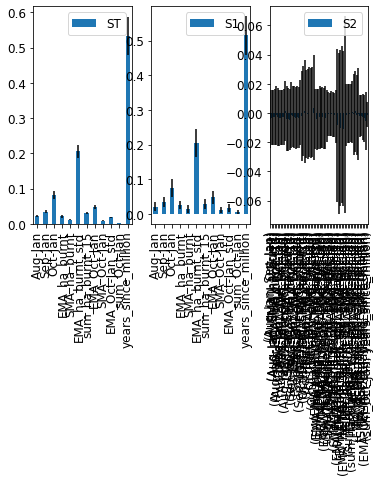

In [845]:
total_Si, first_Si, second_Si = Si.to_df()
Si.plot()

### Mucking around

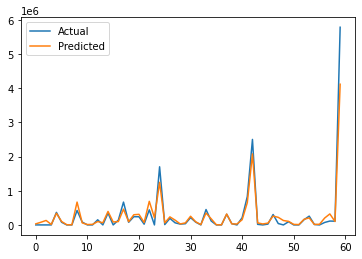

In [361]:
X, y = df.drop(columns=['ha_burnt']), df.ha_burnt
model.fit(X, y)
whole_preds = model.predict(X)
plt.plot(y)
plt.plot(whole_preds)
plt.legend(['Actual', 'Predicted'])
plt.show()

In [365]:
x = whole_preds
n = x.size
t = np.arange(0, n)
p = np.polyfit(t, x, 1) 
p[0], p[1]

(7157.398721867187, 59742.73770491806)

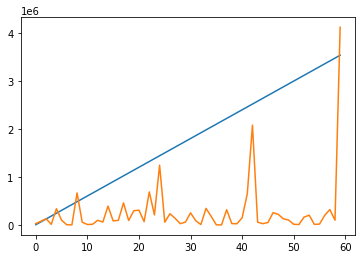

In [367]:
plt.plot(t, (p[0]+t*p[1]))
plt.plot(t, x)
plt.show()

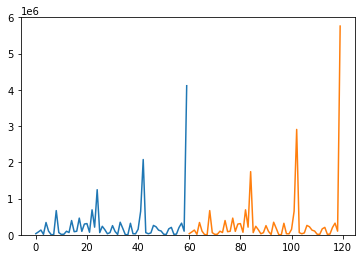

In [387]:
whole_preds2 = list(whole_preds)
for i in range(len(whole_preds2)):
    if whole_preds2[i] > 1000000: 
        whole_preds2[i] *= 1.4
n = [x for x in range(60, 120, 1)]
plt.plot(whole_preds)
plt.plot(n, whole_preds2)
plt.ylim(0, 6000000)
plt.show()

In [168]:
np.sqrt(mse(whole_preds, y))

245266.54793645762

In [394]:
fi = rf_feat_importance(model, X)
fi[:10]

cols       imp
5      EMA_ha_burnt_std  0.174733
3          EMA_ha_burnt  0.150127
11  years_since_million  0.137719
4          SMA_ha_burnt  0.135627
2               Oct-Jan  0.114289
8           SMA_Oct-Jan  0.076620
6       sum_ha_burnt_15  0.056945
7           EMA_Oct-Jan  0.048770
1               Sep-Jan  0.045157
0               Aug-Jan  0.042408

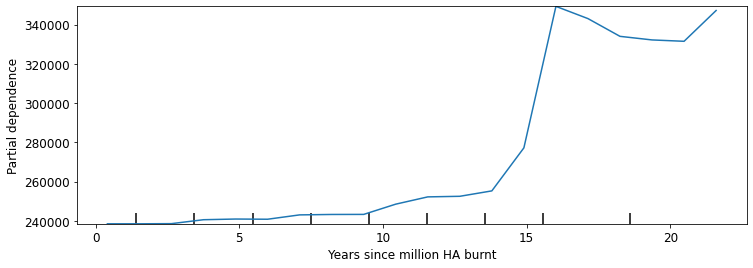

In [427]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(model, X, ['years_since_million'],
                        grid_resolution=20, ax=ax);
plt.xlabel('Years since million HA burnt')
plt.savefig("partialdep.png", dpi=300)

In [403]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import fetch_california_housing

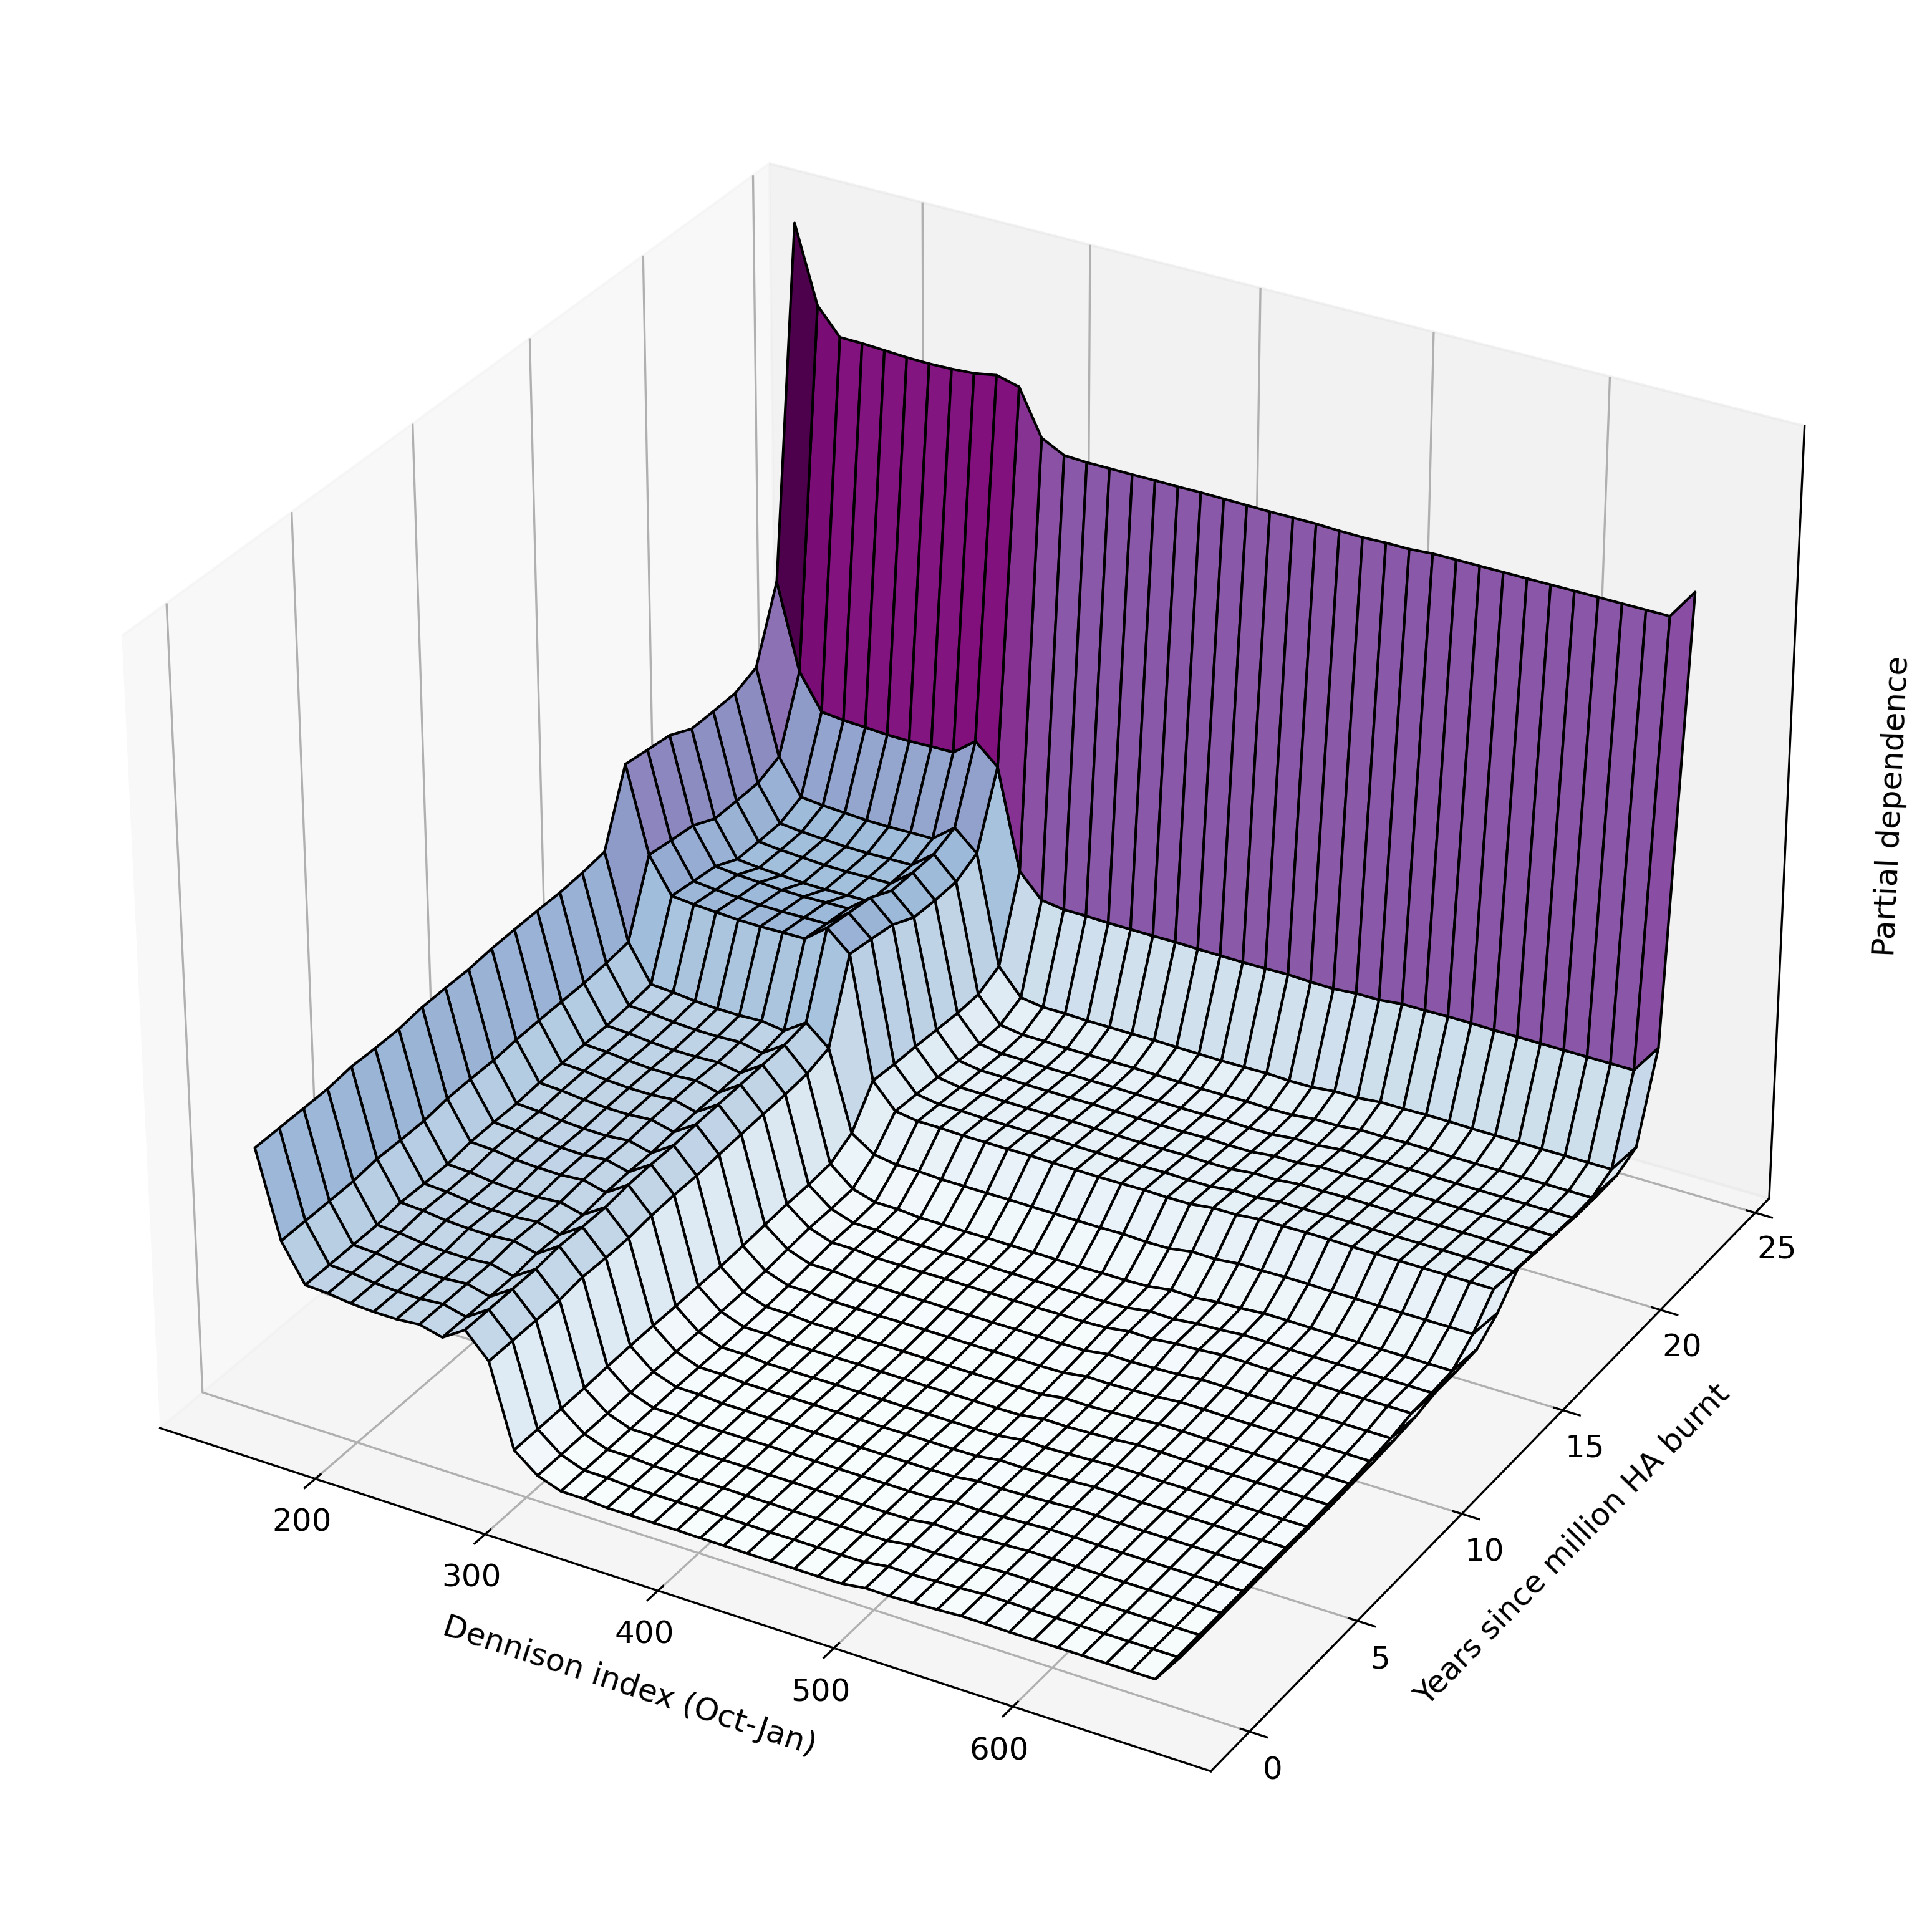

In [423]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(12,10), dpi=300)
features = ('Oct-Jan', 'years_since_million')
pdp, axes = partial_dependence(model, X, features=features,
                               grid_resolution=40)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel('Dennison index (Oct-Jan)')
ax.set_ylabel('Years since million HA burnt')
ax.set_zlabel('Partial dependence')
ax.zaxis.set_ticks([])
ax.tick_params(axis='both', which='major', pad=0)
#  pretty init view
#ax.view_init(elev=22, azim=122)
#plt.colorbar(surf)
plt.subplots_adjust(top=0.9)
plt.savefig("3dpartialdep.png", dpi=300)
plt.show()

### RNN with feature-engineering

In [790]:
df_nn = df.astype(float)
dep_var = 'ha_burnt'
df_nn.ha_burnt = df_nn.ha_burnt + 10
df_nn.head()

Aug-Jan  Sep-Jan  Oct-Jan  ha_burnt  EMA_ha_burnt  SMA_ha_burnt  \
0    784.1    727.2    659.4      10.0           0.0           0.0   
1   1189.6    949.7    897.2      10.0           0.0           0.0   
2    481.3    371.6    285.1      10.0           0.0           0.0   
3    695.2    426.0    401.2      10.0           0.0           0.0   
4    276.1    250.4    235.3  366010.0       36600.0       73200.0   

   EMA_ha_burnt_std  sum_ha_burnt_15  EMA_Oct-Jan  SMA_Oct-Jan  \
0          0.000000              0.0    659.40000      659.400   
1          0.000000              0.0    754.52000      778.300   
2          0.000000              0.0    566.75200      613.900   
3          0.000000              0.0    500.53120      560.725   
4     149480.148816         366000.0    394.43872      495.640   

   EMA_Oct-Jan_std  sum_Oct-Jan  years_since_million  
0         0.000000        659.4                  0.0  
1       168.149993       1556.6                  1.0  
2       305.756319       1841.7                  2.0  
3       245.787638       2242.9                  3.0  
4       240.918888       2478.2                  4.0

In [791]:
cont_nn,cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)

In [792]:
train_idx = [x for x in range(0, 45)]
valid_idx = [x for x in range(45, 60)]
splits = (list(train_idx), list(valid_idx))

In [793]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [794]:
dls = to_nn.dataloaders(8)

In [795]:
y = to_nn.train.y
y.min(),y.max()

(10.0, 2500010.0)

In [796]:
learn = tabular_learner(dls, y_range=(0,2500010.0), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.02290867641568184)

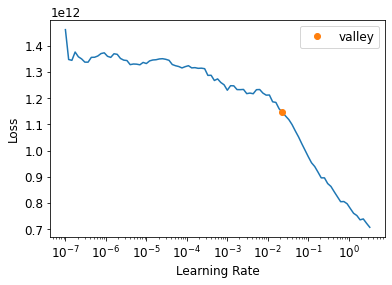

In [797]:
learn.lr_find()

In [798]:
learn.fit_one_cycle(100, 0.009)

In [799]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

864976.912598

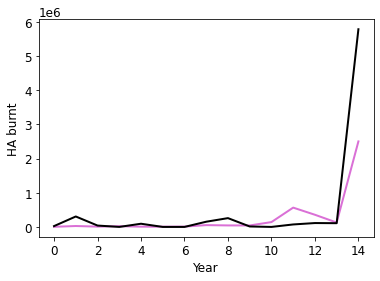

In [803]:
plt.plot(preds, color='orchid', linewidth=2)
plt.plot(targs, color='black', linewidth=2)
plt.xlabel('Year')
plt.ylabel('HA burnt')
plt.savefig("lstmpred.png", dpi=300)
plt.show()

### Fast Fourier transform

In [325]:
from scipy.fft import fft, fftfreq

Fs = 60 # Sampling rate
t  = np.arange(0,1,1/Fs)

signal_fft = fft(df.ha_burnt.values)
frequencies = scipy.fft.fftfreq(np.size(t), 1/Fs)

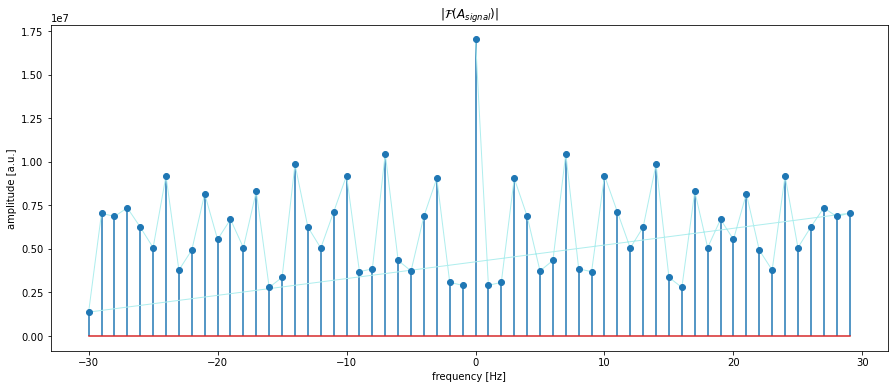

In [326]:
fig=plt.figure(2, figsize=(15,6))
plt.clf()
plt.plot(frequencies, np.abs(signal_fft), lw=1.0, c='paleturquoise')
plt.stem(frequencies, np.abs(signal_fft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$");

Filter by frequency:

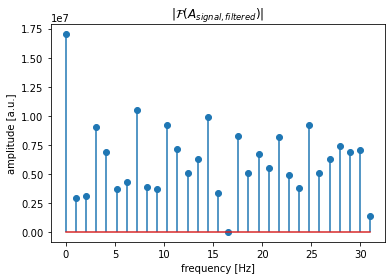

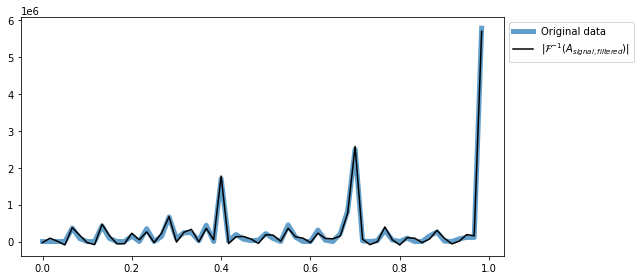

In [327]:
def find_closest_within_array(array, value):
    numpy_array = np.asarray(array) 
    idx = (np.abs(numpy_array-value)).argmin()
    return array[idx], idx

frequency_eval_max = 60
signal_rfft = scipy.fft.rfft(df.ha_burnt.values, n=frequency_eval_max)
n = np.shape(signal_rfft)[0] # np.size(t)
frequencies_rel = n*Fs/frequency_eval_max * np.linspace(0,1,int(n))

filter_frequency = 17
val, idx = find_closest_within_array(frequencies_rel, 
                                     filter_frequency)
signal_rfft[idx] = 0
signal_filtered = scipy.fft.irfft(signal_rfft)

fig=plt.figure(5)
plt.clf()
plt.stem(frequencies_rel, np.abs(signal_rfft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal, filtered})|$")

fig=plt.figure(6, figsize=(9,4))
plt.clf()
plt.plot(t, df.ha_burnt.values, label="Original data", lw=5, alpha=0.7)
plt.plot(t, signal_filtered,  c='k',
         label="$|\mathcal{F}^{-1}(A_{signal, filtered})|$")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

Amplitude filtering:

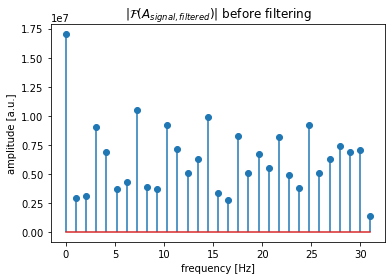

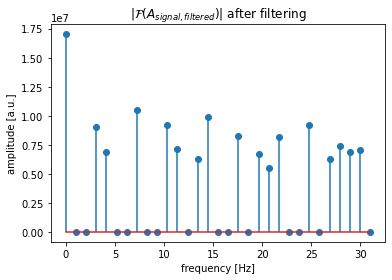

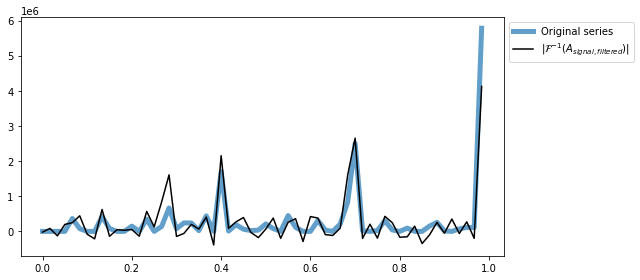

In [335]:
frequency_eval_max = 60
signal_rfft = scipy.fft.rfft(df.ha_burnt.values, n=frequency_eval_max)
n = np.shape(signal_rfft)[0] # np.size(t)
frequencies_rel = n*Fs/frequency_eval_max * np.linspace(0,1,int(n))

fig=plt.figure(7)
plt.clf()
plt.stem(frequencies_rel, np.abs(signal_rfft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal, filtered})|$ before filtering")
plt.savefig("prefilter.png", dpi=300)

pass_limit = 5200000
signal_rfft[np.abs(signal_rfft)<pass_limit]=0
signal_filtered = scipy.fft.irfft(signal_rfft)

fig=plt.figure(8)
plt.clf()
plt.stem(frequencies_rel, np.abs(signal_rfft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal, filtered})|$ after filtering")
plt.savefig("postfilter.png", dpi=300)

fig=plt.figure(9, figsize=(9,4))
plt.clf()
plt.plot(t, df.ha_burnt.values, label="Original series", lw=5, alpha=0.7)
plt.plot(t, signal_filtered,  c='k',
         label="$|\mathcal{F}^{-1}(A_{signal, filtered})|$")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig("fourierfilter.png", dpi=300)
plt.show()

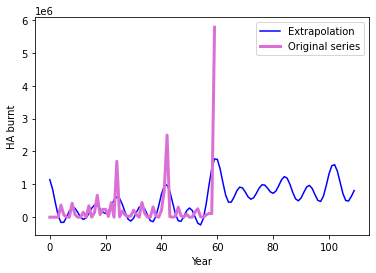

In [393]:
import numpy as np
import pylab as pl
from numpy import fft
    
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 7                  # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    h = 1000000
    x_freqdom=[ x_freqdom[i] if np.absolute(x_freqdom[i])>=h else 0 for i in range(len(x_freqdom))]
    #x_freqdom = fourierFilter(x_freqdom, 4200000)
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

def fourierFilter(signal, pass_limit):
    signal[np.abs(signal)>pass_limit]=0
    return signal
    
def main():
    x = np.array(df.ha_burnt.values)
    n_predict = 50
    extrapolation = fourierExtrapolation(x, n_predict)
    pl.plot(np.arange(0, extrapolation.size), extrapolation, 'blue', 
            label = 'Extrapolation')
    pl.plot(np.arange(0, x.size), x, 'orchid', 
            label = 'Original series', linewidth = 3)
    pl.legend()
    pl.xlabel('Year')
    pl.ylabel('HA burnt')
    pl.savefig('fourier_ext.png', dpi=300)
    pl.show()
    
main()

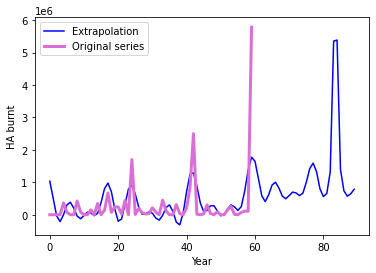

In [344]:
x = np.array(df.ha_burnt.values)
n_predict = 30
extrapolation = fourierExtrapolation(x, n_predict)
extrapolation[-10:] = [ 560897.95509503,  655426.89333459, 
                       1317221.90493269, 5353077.36003446, 
                       5384489.16020598, 1397689.86795303, 
                       739035.38489022,  572722.44748885,  
                       645979.45719541, 785248.70804576]
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'blue', 
            label = 'Extrapolation')
pl.plot(np.arange(0, x.size), x, 'orchid', 
            label = 'Original series', linewidth = 3)
pl.legend()
pl.xlabel('Year')
pl.ylabel('HA burnt')
pl.savefig('fourier_ext.png', dpi=300)
pl.show()

In [304]:
df_train = df.iloc[:50]
df_test = df.iloc[50:]
X_train, y_train = df_train.drop(columns=['ha_burnt']), df_train.ha_burnt
X_test, y_test = df_test.drop(columns=['ha_burnt']), df_test.ha_burnt
n_predict = 100
extrapolation = fourierExtrapolation(y_train, n_predict)
y_pred = extrapolation[-10:]
np.sqrt(mse(y_pred, y_test))

1889506.6491621765

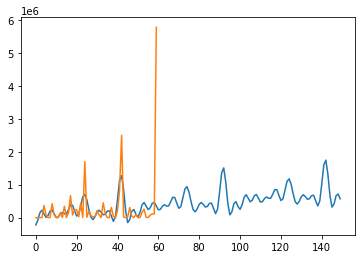

In [305]:
plt.plot(extrapolation)
plt.plot(df.ha_burnt.values);

### LSTM

In [173]:
target_sensor = "ha_burnt"
features = list(df.columns.difference([target_sensor]))

forecast_lead = 5
target = f"{target_sensor}_lead{forecast_lead}"

df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

In [174]:
df_train = df[:45]
df_test = df[45:]
len(df_train), len(df_test)

(45, 10)

In [175]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [176]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [177]:
i = 20
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X.shape)

torch.Size([4, 12])


In [178]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

# batch-size = 3
# sequence length = 4
# features = 15

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)

torch.Size([3, 4, 12])


In [179]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 5

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 5, 12])
Target shape: torch.Size([4])


In [180]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [181]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [187]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(1000000000):
    if ix_epoch % 100000000 == 0:
        print(f"Epoch {ix_epoch}\n---------")
        train_model(train_loader, model, loss_function, optimizer=optimizer)
        test_model(test_loader, model, loss_function)
        print()

Untrained test
--------
Test loss: 24.037514170010883

Epoch 0
---------
Train loss: 0.8731859400868416
Test loss: 24.03893893957138

Epoch 100000000
---------
Train loss: 0.8868567695220312
Test loss: 24.04088604450226

Epoch 200000000
---------
Train loss: 0.881949927036961
Test loss: 24.04001486301422

Epoch 300000000
---------
Train loss: 0.8723109842588505
Test loss: 24.037783617774647

Epoch 400000000
---------
Train loss: 0.8698551418880621
Test loss: 24.03600161274274

Epoch 500000000
---------
Train loss: 0.8885616216187676
Test loss: 24.03540264070034

Epoch 600000000
---------
Train loss: 0.8930830576767524
Test loss: 24.032687574625015

Epoch 700000000
---------
Train loss: 0.8707723257442316
Test loss: 24.03860160211722

Epoch 800000000
---------
Train loss: 0.8862989588330189
Test loss: 24.035018776853878

Epoch 900000000
---------
Train loss: 0.8699099949250618
Test loss: 24.03507537643115



In [188]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

    ha_burnt_lead5  Model forecast
0          78000.0   129799.656250
1              0.0   118409.085938
2              0.0   116400.468750
3         423000.0   154822.656250
4          83000.0   170586.156250
5              0.0   195567.281250
6              0.0   202577.015625
7         150000.0   218196.281250
8              0.0   225253.796875
9         347000.0   219325.578125
10             0.0   218185.203125
11        139000.0   216535.250000
12        667000.0   217092.093750
13         77000.0   225212.890625
14        240000.0   247016.406250
15        239000.0   239428.937500
16         22000.0   237924.609375
17        441000.0   261570.406250
18             0.0   268684.625000
19       1700000.0   271874.937500
20         10000.0   269133.281250
21        191000.0   254588.109375
22         62000.0   261020.031250
23         24000.0   251440.968750
24         35000.0   248975.296875
25        213000.0   228766.437500
26         81000.0   238300.000000
27             0.0  

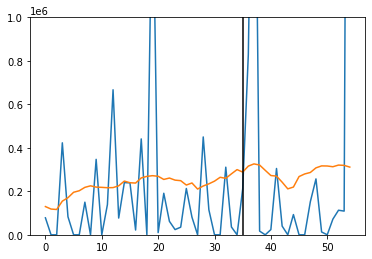

In [191]:
import matplotlib.pyplot as plt

plt.plot(df_out.ha_burnt_lead5)
plt.plot(df_out['Model forecast'])
plt.axvline(x=35, color='black')
plt.ylim(0, 1000000)
plt.show()